# ***Deep Learning - Assignment 4***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
# Data reading
import numpy as np
import pandas as pd
from scipy.io import arff

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow.keras import (
    Model, Sequential, layers, initializers, optimizers, losses, metrics
)

# scikit-learn
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, MinMaxScaler)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)

# EDA
from pandas_profiling import ProfileReport

# Synthetic data evaluation
from table_evaluator import TableEvaluator

# Typing
from typing import Tuple, List, Dict, Any

# Randomness
import random

### ***Consistency***

Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constant definitions***

Next, let's define some constant variables:

In [3]:
# Define the path containing the Data (german_credit.arff, diabetes.arff)
DATA_PATH = "./Data"

# Define the path containing the diabetes data
DIABETES_PATH = f"{DATA_PATH}/diabetes.arff"

# Define the path containing the german credit data
GERMAN_CREDIT_PATH = f"{DATA_PATH}/german_credit.arff"

# Define batch size
BATCH_SIZE = 32

# Define learning rate
LEARNING_RATE = 0.0002

# Define momentum rate
MOMENTUM_RATE = 0.5

# Define number of epochs
DIABETES_NUM_EPOCHS = 1500
G_CREDIT_NUM_EPOCHS = 200

# Define label smoothing value
LABEL_SMOOTHING = 0.1

# Define size of test set
TEST_SIZE = 0.3

# Define weight initialization object
WEIGHT_INIT = initializers.RandomNormal(mean=0.0, stddev=0.02)

### ***Auxiliary methods***

Next, let's define some auxiliary methods:

In [4]:
def read_arff(file_path: str) -> pd.DataFrame:
  """Method to read arff file as data frame.

  Args:
    file_path (str): Path to arff file.

  Returns:
    pd.DataFrame: Read data.

  """
  # Load arff data
  data, meta = arff.loadarff(file_path)
  # Create data frame from data and column names
  arff_df = pd.DataFrame(data, columns=meta.names())
  # Decode byte objects to strings
  for n, t in zip(meta.names(), meta.types()):
    if t == "nominal":
      arff_df[n] = arff_df[n].str.decode("utf-8")
  # Make sure class column is called class
  if '21' in arff_df.columns:
    arff_df["class"] = arff_df["21"]
    arff_df.drop(["21"], axis=1, inplace=True)
  return arff_df


def get_num_and_cat_columns(df: pd.DataFrame) -> Tuple[List[str], ...]:
  """Method to get numeric and categorical column names from
    data frame not including class column.

  Args:
      df (pd.DataFrame): Data frame.

  Returns:
      Tuple[List[str, ...]]: Numeric and categorical column names.
  """
  # Get all categorical columns
  cat_cols = df.select_dtypes(include=['object', 'category']).columns
  cat_cols = cat_cols.drop("class").to_list()
  # Create empty list for numeric columns
  num_cols = []
  # Loop over all number columns
  for col in df.select_dtypes(include=['number']).columns:
    # Add numeric column
    if len(df[col].unique()) > 4:
      num_cols.append(col)
    # Add categorical number column
    else:
      cat_cols.append(col)
  return num_cols, cat_cols


def pre_process_data(
    df: pd.DataFrame, num_cols: List[str], cat_cols: List[str]
) -> Tuple[pd.DataFrame, LabelEncoder, MinMaxScaler, OneHotEncoder]:
  """Method to preprocess a data frame.

  Args:
    df (pd.DataFrame): Data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.

  Returns:
    Tuple[pd.DataFrame, LabelEncoder, MinMaxScaler, OneHotEncoder]: Clean data
      frame, label transformer, numeric transformer, categorical transformer.

  """
  # Define label transformer for dataset
  l_encoder = LabelEncoder()

  # Define numeric transformer for dataset
  n_scalar = MinMaxScaler(feature_range=(-1, 1))

  # Define categorical transformer for dataset
  c_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  # Copy to not change the original
  df = df.copy()

  if len(num_cols) > 0:
    # Convert all numeric columns to float32
    df[num_cols] = df[num_cols].astype(np.float32)
    # Normalize numeric columns
    df[num_cols] = (n_scalar.fit_transform(df[num_cols]))

  if len(cat_cols) > 0:
    # One hot encoding of the categorical variable
    c_encoder.fit(df[cat_cols])
    df.loc[:, c_encoder.get_feature_names_out()] = c_encoder.fit_transform(
        df[cat_cols]
    )
    # Drop original columns
    df.drop(cat_cols, axis=1, inplace=True)

    # Smooth all one hot columns
    for col in c_encoder.get_feature_names_out():
      df[col] = df[col].apply(smooth_binary)

    # Convert all categorical columns to float32
    df[c_encoder.get_feature_names_out()
      ] = df[c_encoder.get_feature_names_out()].astype(np.float32)

  # Convert class column to [0,1]
  labels = df.pop("class")
  df["class"] = l_encoder.fit_transform(labels)

  return df, l_encoder, n_scalar, c_encoder


def inverse_pre_process_data(
    clean_df: pd.DataFrame, num_cols: List[str], cat_cols: List[str],
    l_encoder: LabelEncoder, n_scalar: MinMaxScaler, c_encoder: OneHotEncoder
) -> pd.DataFrame:
  """Method to inverse preprocess of the a data frame.

  Args:
    clean_df (pd.DataFrame): Clean data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.
    clean_diabetes_df (LabelEncoder): Label transformer.
    n_scalar (MinMaxScaler): Numeric transformer.
    c_encoder (OneHotEncoder): Categorical transformer.

  Returns:
    pd.DataFrame: Data frame.

  """
  # Copy to not change the original
  clean_df = clean_df.copy()

  # Return numeric to original
  if len(num_cols) > 0:
    # de-normalize numeric columns
    clean_df[num_cols] = (n_scalar.inverse_transform(clean_df[num_cols]))
    # Convert all float64 to float32
    clean_df[num_cols] = clean_df[num_cols].astype(np.float64)

  # Return categorical to original
  if len(cat_cols) > 0:
    # Convert one hot encoding of the categorical variable to original
    clean_df[cat_cols] = c_encoder.inverse_transform(
        clean_df.loc[:, c_encoder.get_feature_names_out()]
    )
    # Remove one hot encoding of the categorical variable
    clean_df.drop(c_encoder.get_feature_names_out(), axis=1, inplace=True)

  # Convert class column to original
  clean_df["class"] = clean_df["class"].astype(int)
  clean_df["class"] = l_encoder.inverse_transform(clean_df["class"])

  return clean_df


def smooth_binary(x: int) -> float:
  """Method to smooth a binary value.

  Args:
      x (int): Binary value

  Returns:
      float: Smooth binary value.
  """
  return x * (1.0 - LABEL_SMOOTHING) + 0.5 * LABEL_SMOOTHING

### ***Exploratory data analysis***

##### ***Diabetes exploratory data analysis***

Let's do some EDA on the diabetes datasets. We begin with reading the data:

In [5]:
# Read diabetes data
diabetes_df = read_arff(DIABETES_PATH)

Next, lets create an EDA report:

In [6]:
# Create EDA report
diabetes_profile = ProfileReport(diabetes_df, title="Diabetes EDA")
# Export EDA report to html file
diabetes_profile.to_file("diabetes_eda.html")
# Show EDA report
diabetes_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [7]:
# Get numeric and categorical column names
diabetes_num_cols, diabetes_cat_cols = get_num_and_cat_columns(diabetes_df)
# Pre process
clean_diabetes_df, diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder = (
    pre_process_data(diabetes_df, diabetes_num_cols, diabetes_cat_cols)
)

Next, let's create features and class sets:

In [8]:
diabetes_X = clean_diabetes_df.loc[:, clean_diabetes_df.columns != "class"]
diabetes_y = clean_diabetes_df.loc[:, ["class"]]

##### ***German credit exploratory data analysis***

Let's do some EDA on the german credit datasets. We begin with reading the data:

In [9]:
# Read german credit data
g_credit_df = read_arff(GERMAN_CREDIT_PATH)

Next, lets create an EDA report:

In [10]:
# Create EDA report
g_credit_profile = ProfileReport(g_credit_df, title="German Credit EDA")
# Export EDA report to html file
g_credit_profile.to_file("german_credit_eda.html")
# Show EDA report
g_credit_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [11]:
# Get numeric and categorical column names
g_credit_num_cols, g_credit_cat_cols = get_num_and_cat_columns(g_credit_df)
# Pre process
clean_g_credit_df, g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder = (
    pre_process_data(g_credit_df, g_credit_num_cols, g_credit_cat_cols)
)

Next, let's create features and class sets:

In [12]:
g_credit_X = clean_g_credit_df.loc[:, clean_g_credit_df.columns != "class"]
g_credit_y = clean_g_credit_df.loc[:, ["class"]]

### ***Part 1 – Generative Adversarial Networks***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [13]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(
              data_dim, activation="tanh", kernel_initializer=WEIGHT_INIT
          )
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, activation="sigmoid", kernel_initializer=WEIGHT_INIT)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(self, generator: Model, discriminator: Model, latent_dim: int):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.real_bce_metric = metrics.BinaryAccuracy()
    self.fake_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.real_bce_metric,
        self.fake_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
    """Method to apply training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack records and labels
    real_records, labels = data

    # Get data size
    data_size = tf.shape(real_records)[0]

    # Cast one hot labels to float32 for compatibility
    labels = tf.cast(labels, dtype=tf.float32)

    # Sample random points in the latent space for the generator
    # and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, labels], axis=1)

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_labels)

      # concatenate the labels to fake and real records
      real_record_and_labels = tf.concat([real_records, labels], axis=1)
      fake_record_and_labels = tf.concat([fake_records, labels], axis=1)

      # Get discriminator prediction on fake and real records
      real_predictions = self.discriminator(real_record_and_labels)
      fake_predictions = self.discriminator(fake_record_and_labels)

      # Calculate real records loss
      d_real_loss = self.loss_fn(tf.ones((data_size, 1)), real_predictions)

      # Calculate fake records loss
      d_fake_loss = self.loss_fn(tf.zeros((data_size, 1)), fake_predictions)

      # Calculate discriminator and generator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.real_bce_metric.update_state(tf.ones((data_size, 1)), real_predictions)
    self.fake_bce_metric.update_state(
        tf.zeros((data_size, 1)), fake_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_real_acc": self.real_bce_metric.result(),
        "d_fake_acc": self.fake_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a conditional GAN on the diabetes data:

In [14]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
num_class = diabetes_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

# Train CGAN
history = cgan.fit(
    diabetes_X, diabetes_y, epochs=DIABETES_NUM_EPOCHS, shuffle=True,
    batch_size=BATCH_SIZE
)

Epoch 1/1500
24/24 [==============================] - 3s 6ms/step - g_loss: 0.6935 - d_loss: 0.6928 - d_real_acc: 0.8034 - d_fake_acc: 0.8680
Epoch 2/1500
24/24 [==============================] - 0s 6ms/step - g_loss: 0.6949 - d_loss: 0.6936 - d_real_acc: 0.1999 - d_fake_acc: 0.7728
Epoch 3/1500
24/24 [==============================] - 0s 6ms/step - g_loss: 0.7000 - d_loss: 0.6921 - d_real_acc: 0.0057 - d_fake_acc: 0.9612
Epoch 4/1500
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6924 - d_loss: 0.6928 - d_real_acc: 0.7680 - d_fake_acc: 0.2640
Epoch 5/1500
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6960 - d_loss: 0.6945 - d_real_acc: 0.1846 - d_fake_acc: 0.5310
Epoch 6/1500
24/24 [==============================] - 0s 5ms/step - g_loss: 0.7026 - d_loss: 0.6908 - d_real_acc: 0.1958 - d_fake_acc: 0.9938
Epoch 7/1500
24/24 [==============================] - 0s 6ms/step - g_loss: 0.6572 - d_loss: 0.7061 - d_real_acc: 0.8139 - d_fake_acc: 0.0000e+00
Ep

Next, let's plot training metrics:

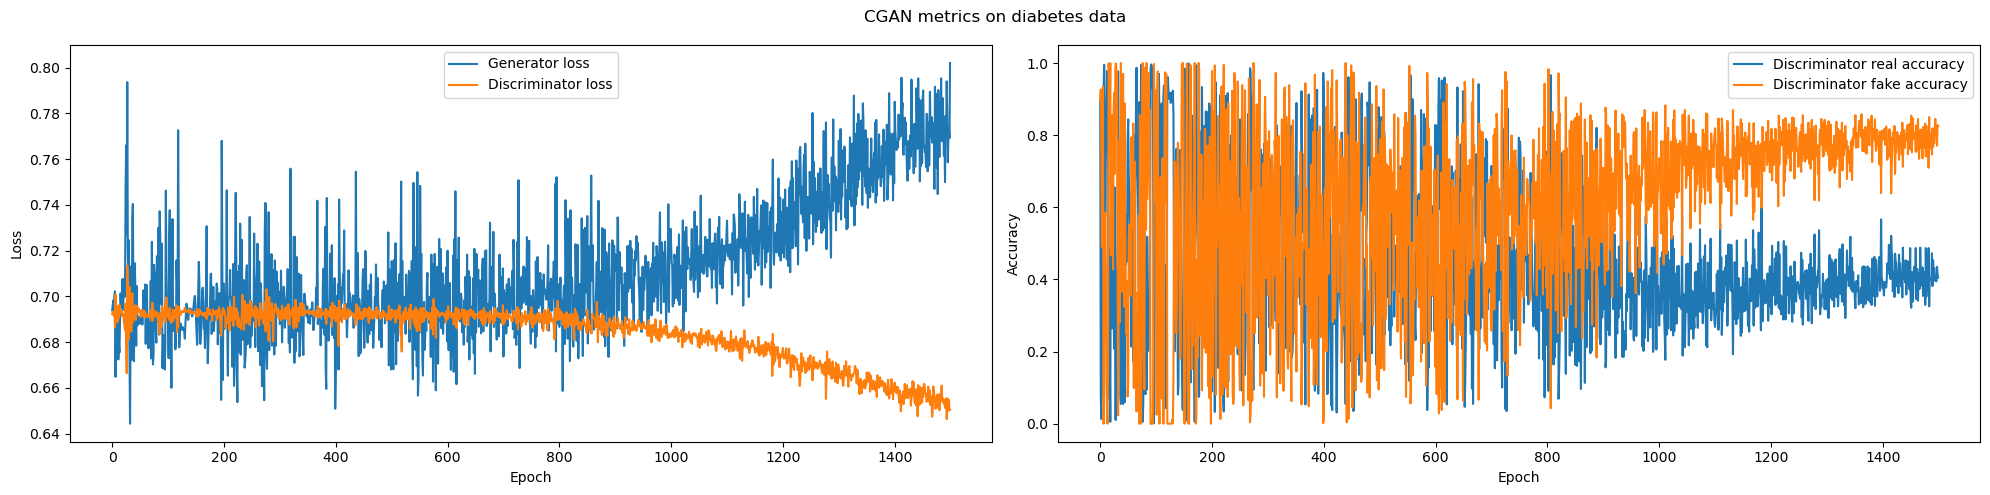

In [15]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [16]:
# Define number of samples to generate
num_samples = diabetes_X.shape[0]

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat([random_latent_vectors, diabetes_y], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, diabetes_y], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_diabetes_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_labels.numpy(), columns=clean_diabetes_df.columns
)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

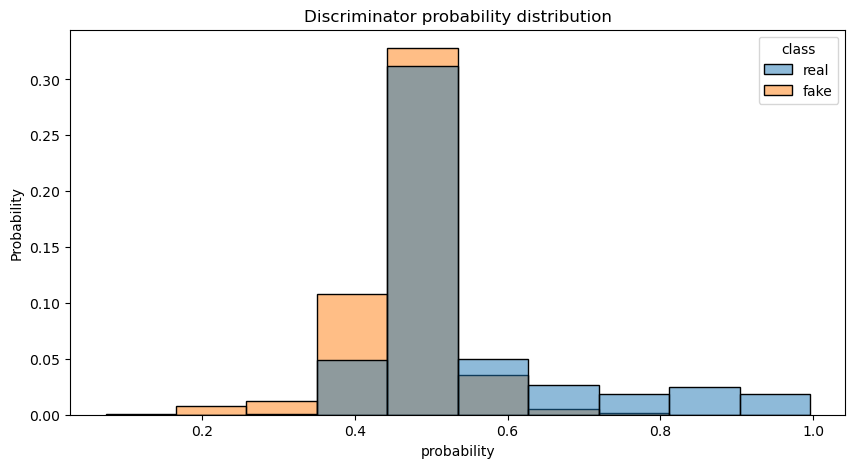

In [17]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [18]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 124


preg        plas        pres       skin        insu       mass  \
4   12.112260  112.149475   67.566643   0.000065    0.000429  32.331638   
5   11.782934   85.598770   69.192291   0.000000    0.000000  29.697657   
21   8.830717  128.888504   93.374084   0.000000    0.000000  37.703804   
36   5.438122  117.604828   85.718674   0.004290    0.303410  22.871758   
40  10.740901  133.581589  100.783974   0.000000    0.000000  40.412453   
44   0.016000   99.370491   78.179893  18.903091  144.469650  22.592644   
48   7.780248  181.730530   83.185707   0.060124    1.773894  30.621618   
58  13.347590  146.820465   71.949440   0.000195    0.000277  24.577005   
84   8.501112  164.522430   89.886108   0.000000    0.000000  41.864967   
88  13.133865  146.943405   85.136963  45.500927  152.575653  43.586731   

        pedi        age            class  
4   0.443855  36.856716  tested_positive  
5   0.291039  47.725697  tested_negative  
21  0.385182  45.195057  tested_negative  
36  0.375250  60.599533  tested_negative  
40  0.214344  53.557690  tested_negative  
44  0.577297  25.129904  tested_negative  
48  0.288105  52.071987  tested_positive  
58  0.162533  45.509865  tested_negative  
84  0.341997  47.141251  tested_positive  
88  0.514725  45.315544  tested_positive

In [19]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 644


preg        plas       pres       skin        insu       mass  \
0   0.047447  131.016357  68.231255  33.254917   32.357910  46.189060   
1   3.196284   78.389961  64.084106  23.853680    0.481211  17.762438   
2   9.926067  122.711708  66.733727   0.000000    0.000000  29.939600   
3   1.185737  151.164093  79.907562  41.725105   20.001362  30.900370   
6   2.735502  182.951630  72.782654  29.494347  327.111816  31.359995   
7   1.734028   88.928505  58.177967  20.302088    0.750962  17.590240   
8   6.907452  130.568420  82.632576   0.105047    0.127299  26.979042   
9   0.102205  172.653275  62.670002  38.831772  197.258514  41.563866   
10  3.079839  118.989555  65.569008  30.337076  185.988358  31.775593   
11  1.173494  106.202240  64.541954  27.124985   78.900269  31.555283   

        pedi        age            class  
0   0.143568  21.743099  tested_positive  
1   0.126705  22.098387  tested_negative  
2   0.264235  42.335754  tested_positive  
3   0.101216  28.761839  tested_negative  
6   0.283950  29.394712  tested_positive  
7   0.116165  21.069225  tested_negative  
8   0.120478  38.489983  tested_positive  
9   0.327483  21.720295  tested_positive  
10  0.468936  23.106045  tested_negative  
11  0.409085  22.633518  tested_positive

Lets evaluate the generated samples using table evaluator:

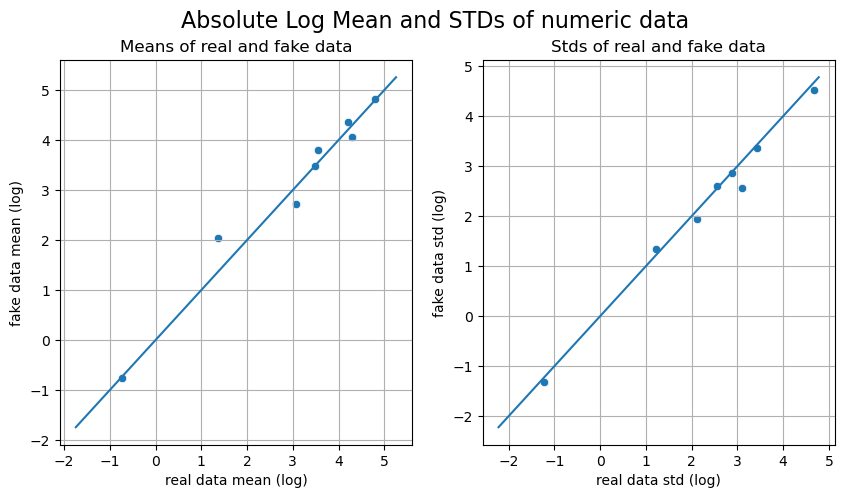

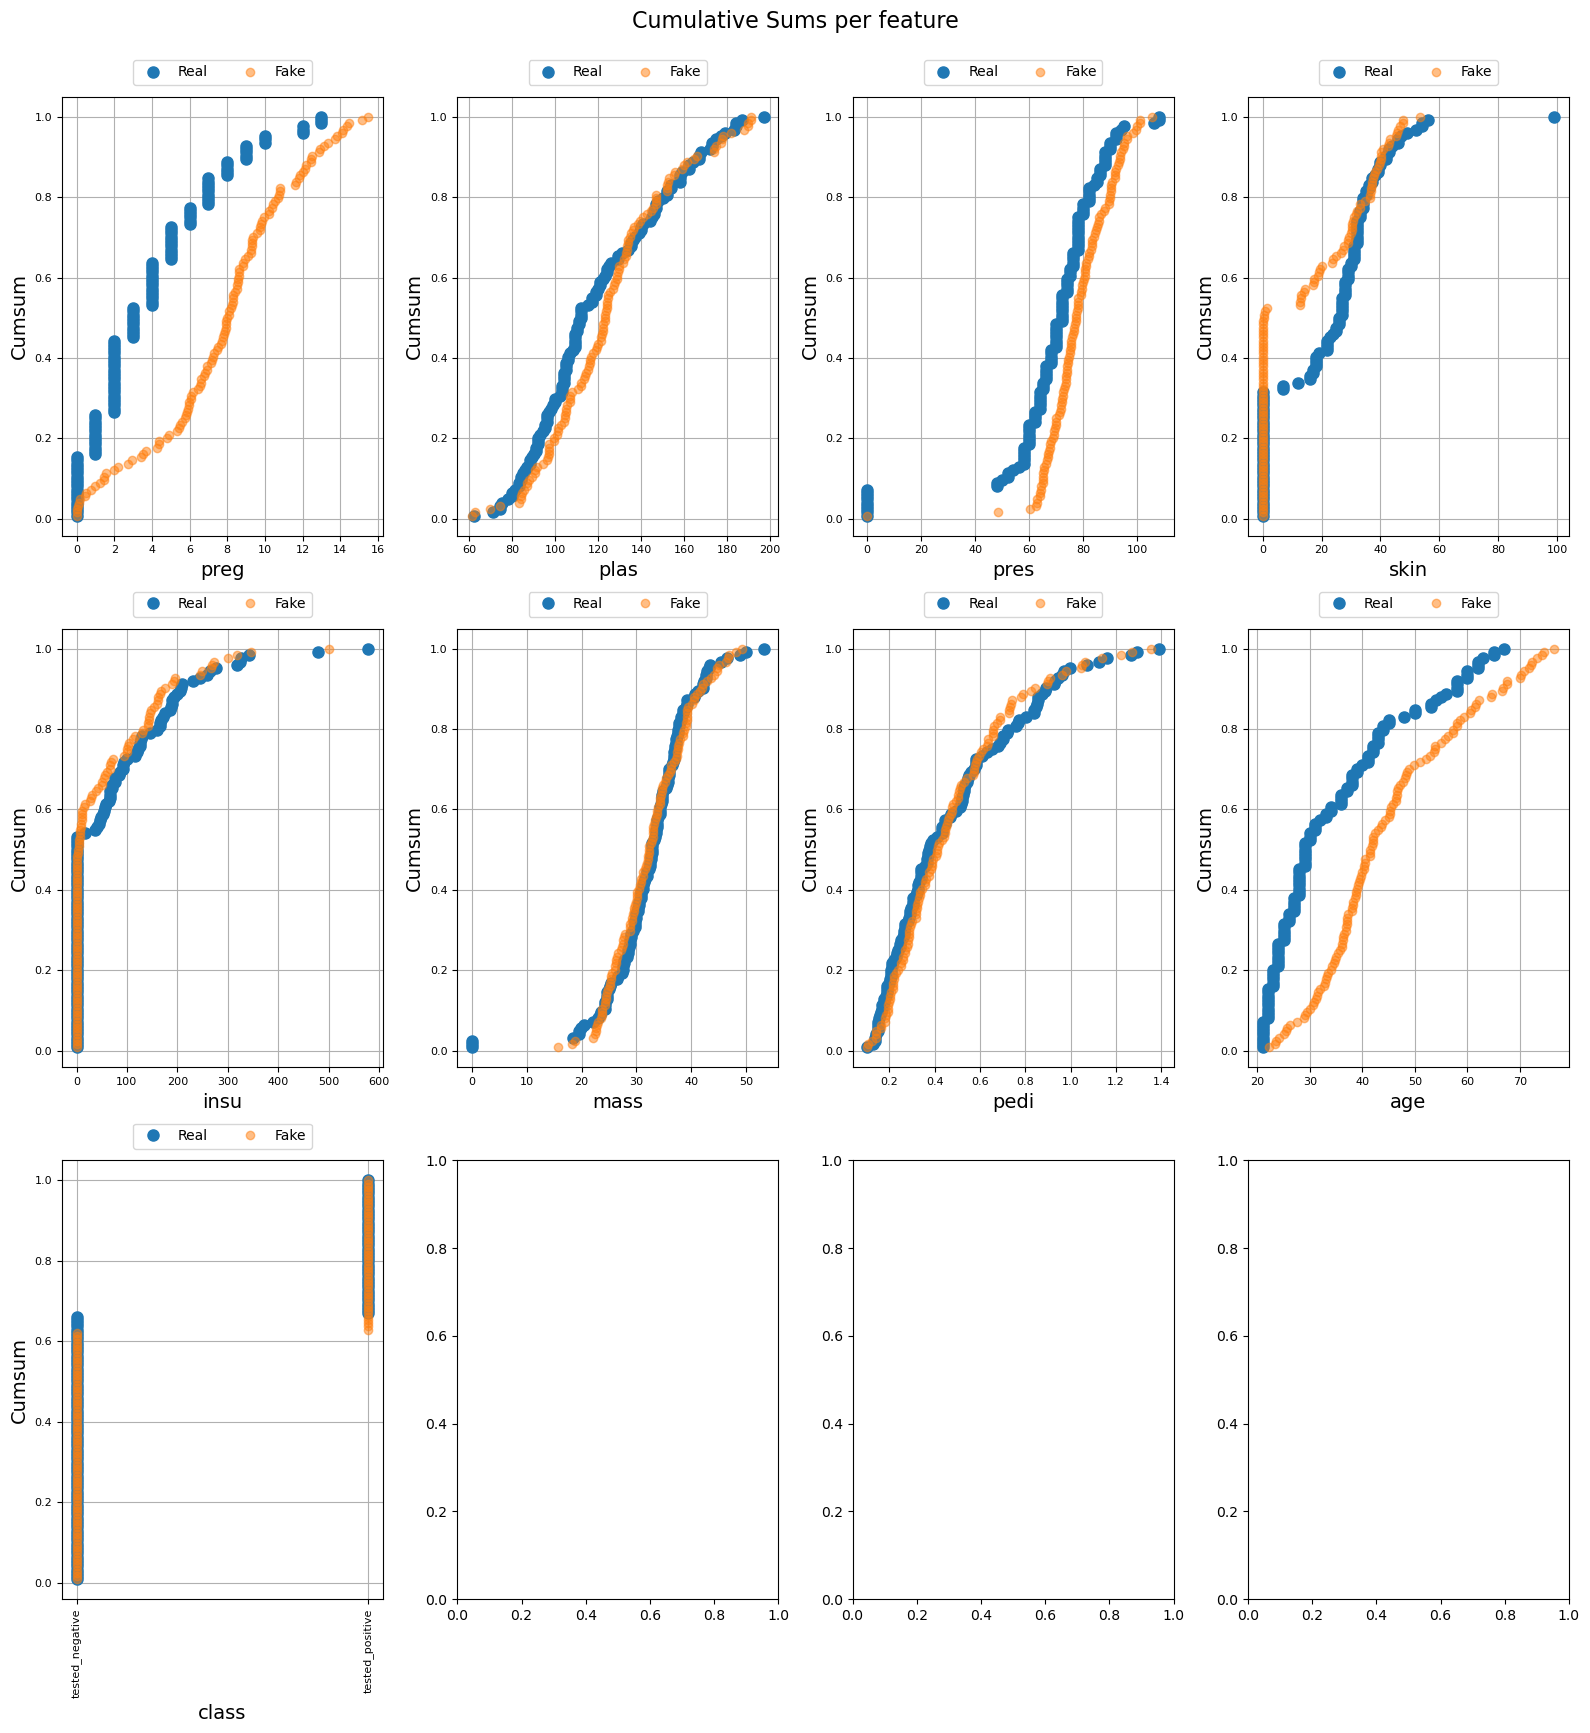

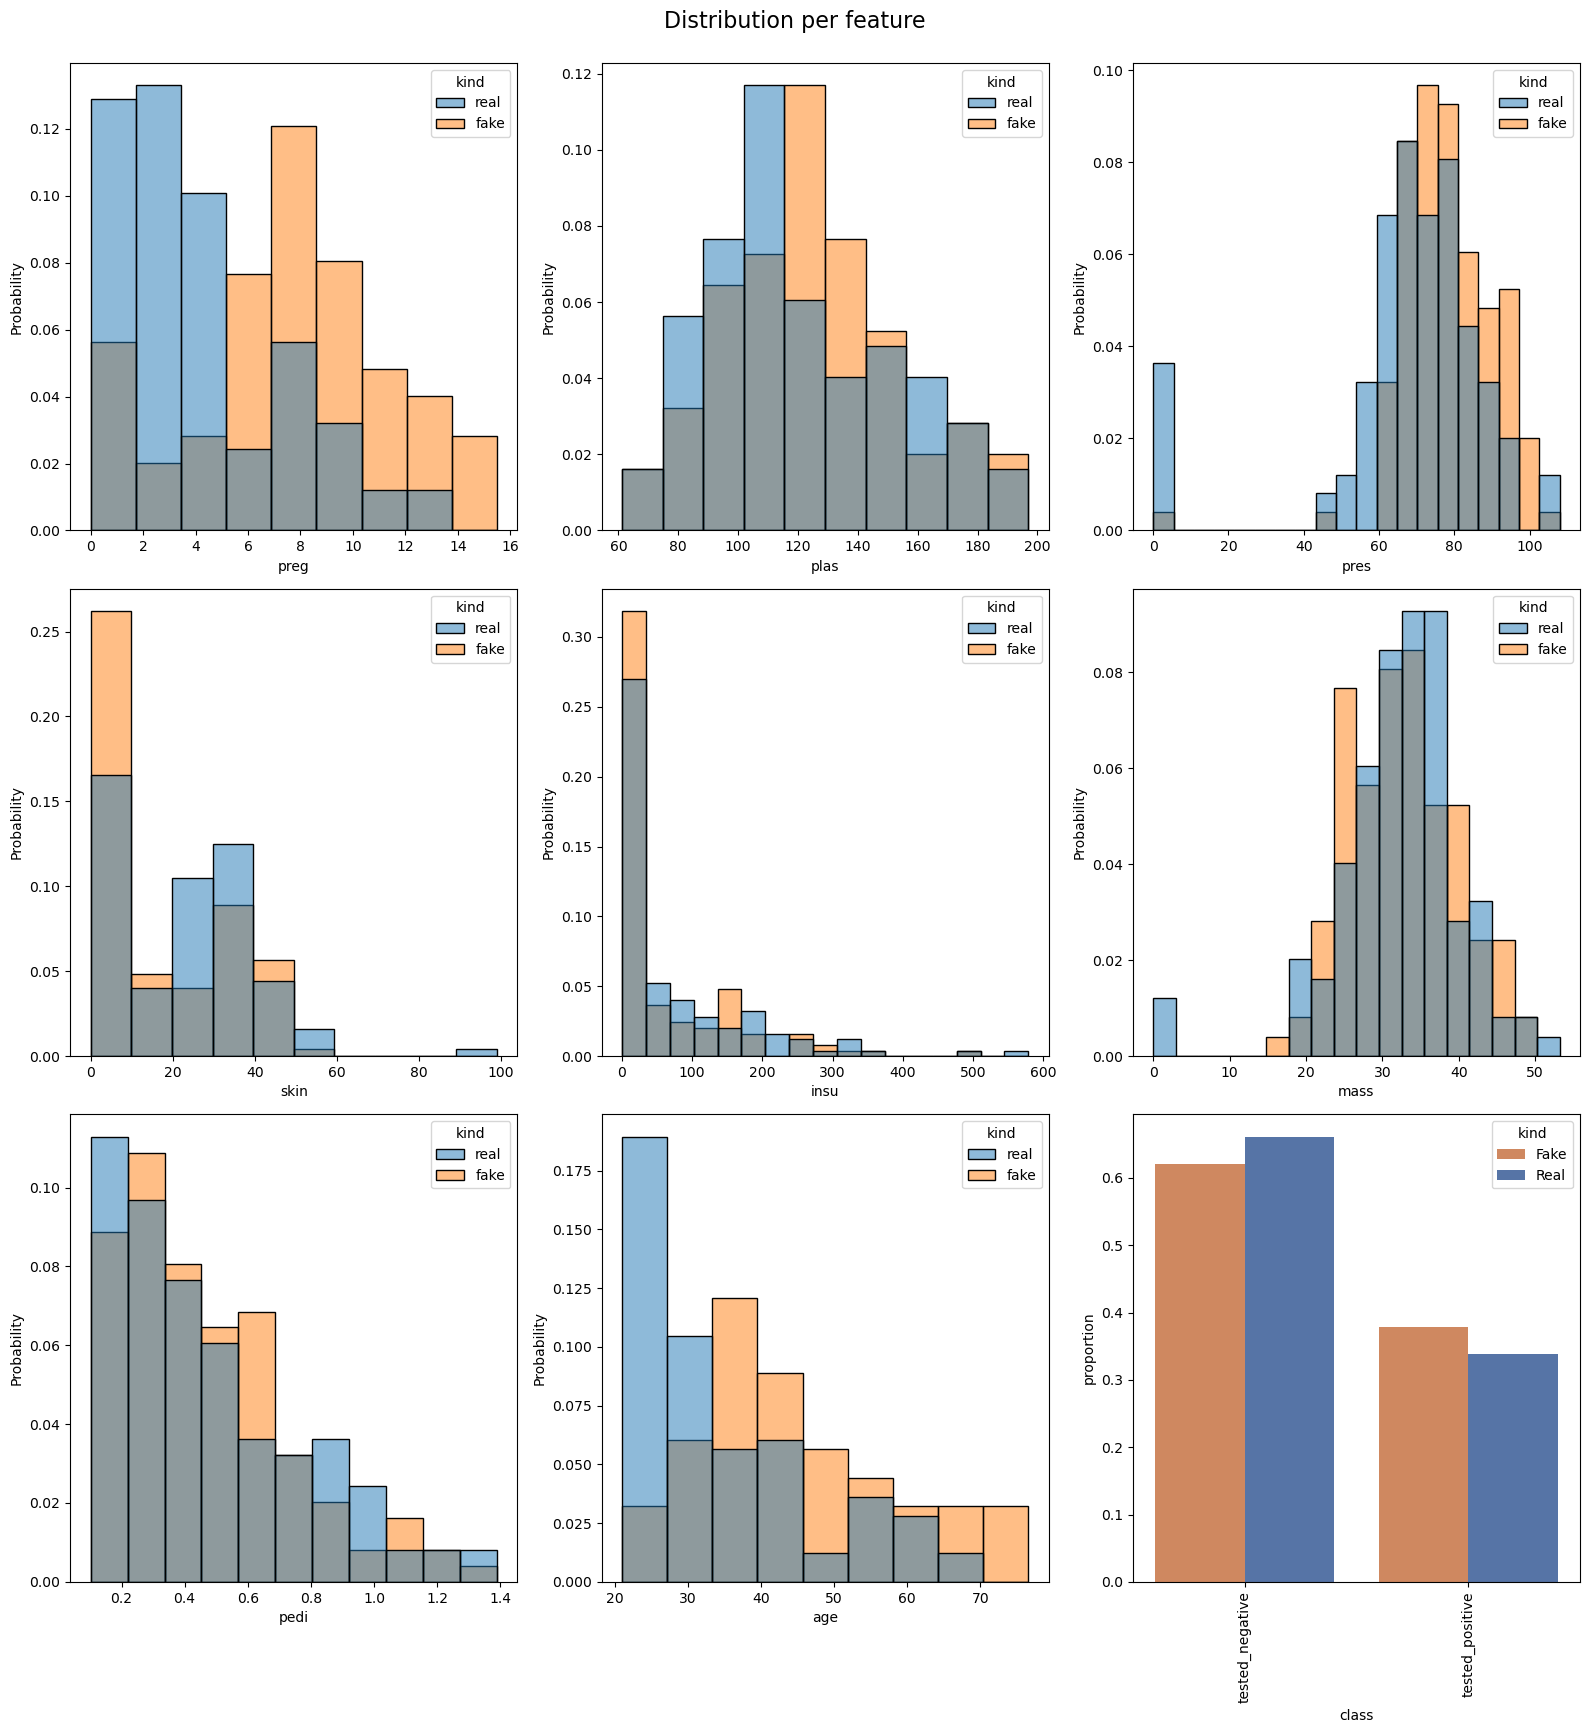

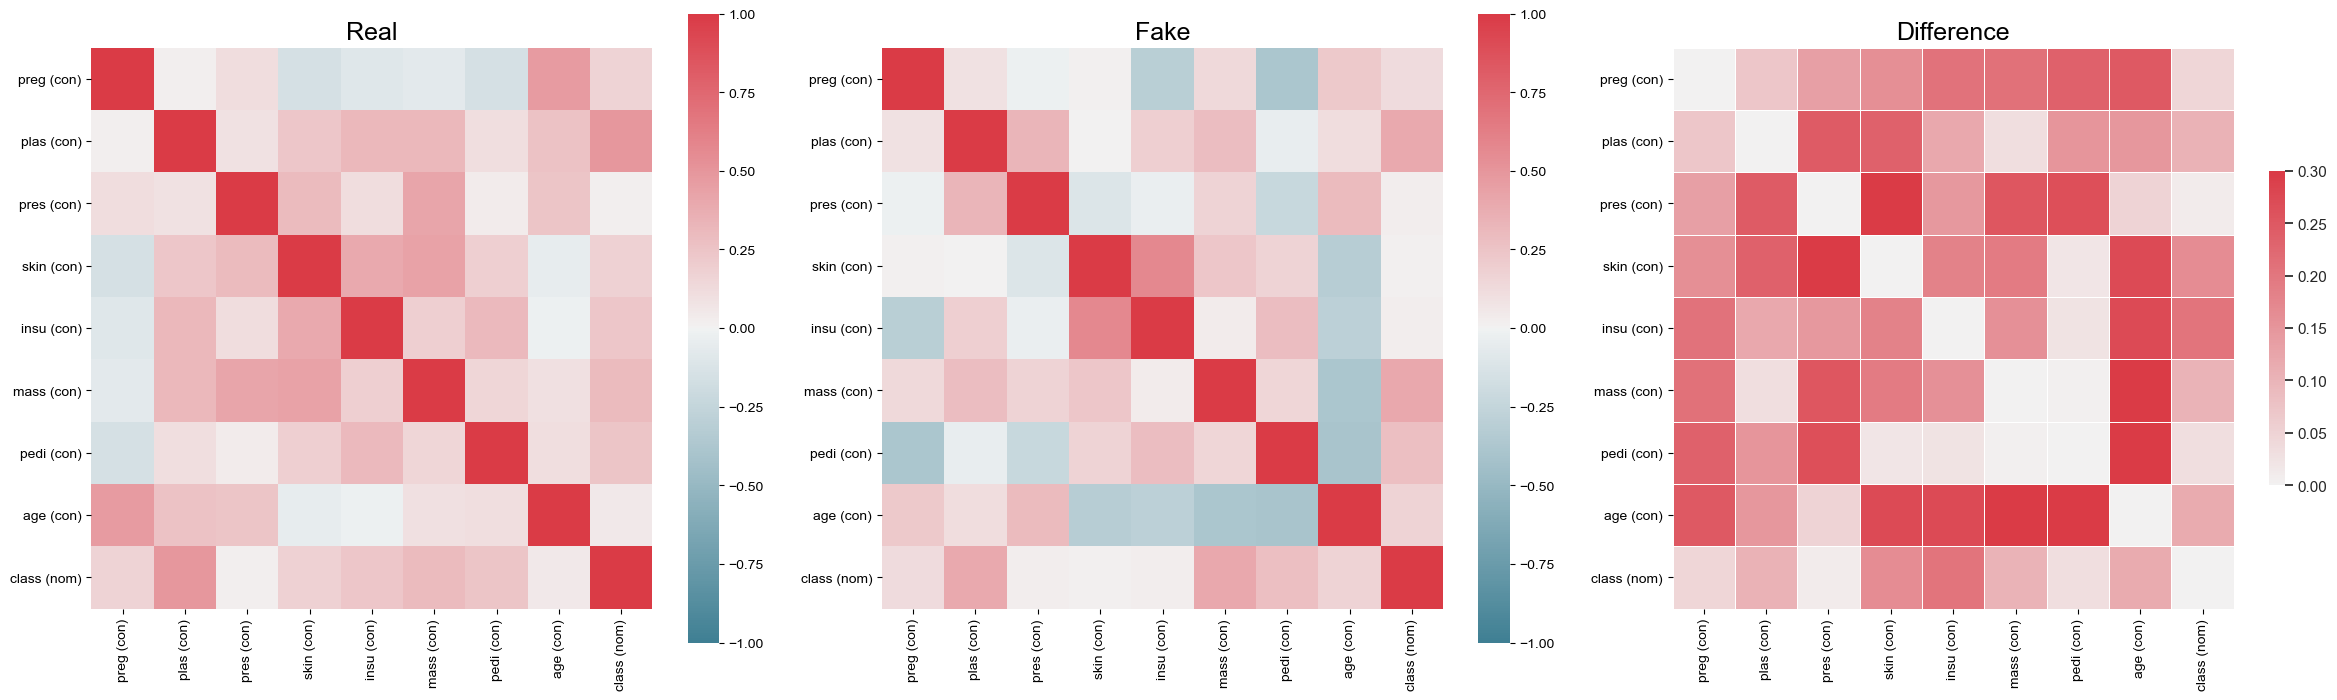

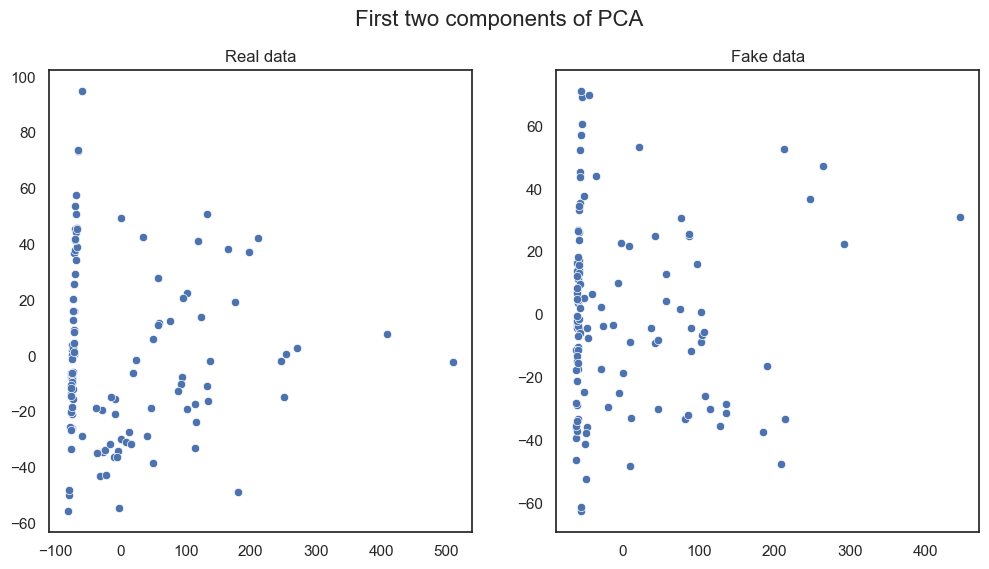


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.8400   0.7200              0.5625
DecisionTreeClassifier_real   0.6800   0.5600              0.3158
LogisticRegression_fake       0.8800   0.6400              0.5152
LogisticRegression_real       0.7600   0.8800              0.6667
MLPClassifier_fake            0.6800   0.6400              0.7857
MLPClassifier_real            0.7600   0.6000              0.2821
RandomForestClassifier_fake   0.8800   0.5200              0.3889
RandomForestClassifier_real   0.5600   0.6800              0.6667

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.8436
nearest neighbor std                     0.6462

Miscellaneous results:
                                  Result
Column Cor

In [21]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df, fooled,
    cat_cols=diabetes_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's train a conditional GAN on the germen credit data:

In [22]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
num_class = g_credit_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

# Train CGAN
history = cgan.fit(
    g_credit_X, g_credit_y, epochs=200, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/200
32/32 [==============================] - 2s 12ms/step - g_loss: 0.6917 - d_loss: 0.6919 - d_real_acc: 0.9053 - d_fake_acc: 0.6964
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.7116 - d_loss: 0.6905 - d_real_acc: 0.0068 - d_fake_acc: 1.0000
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.6945 - d_loss: 0.6853 - d_real_acc: 0.9842 - d_fake_acc: 0.6918
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.7007 - d_loss: 0.6878 - d_real_acc: 0.6592 - d_fake_acc: 0.5647
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.6842 - d_loss: 0.6934 - d_real_acc: 0.9468 - d_fake_acc: 0.1508
Epoch 6/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.7063 - d_loss: 0.6926 - d_real_acc: 0.1498 - d_fake_acc: 0.9556
Epoch 7/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.6767 - d_loss: 0.6978 - d_real_acc: 0.8191 - d_fake_acc: 0.1187
Epoch 8/200


Next, let's plot training metrics:

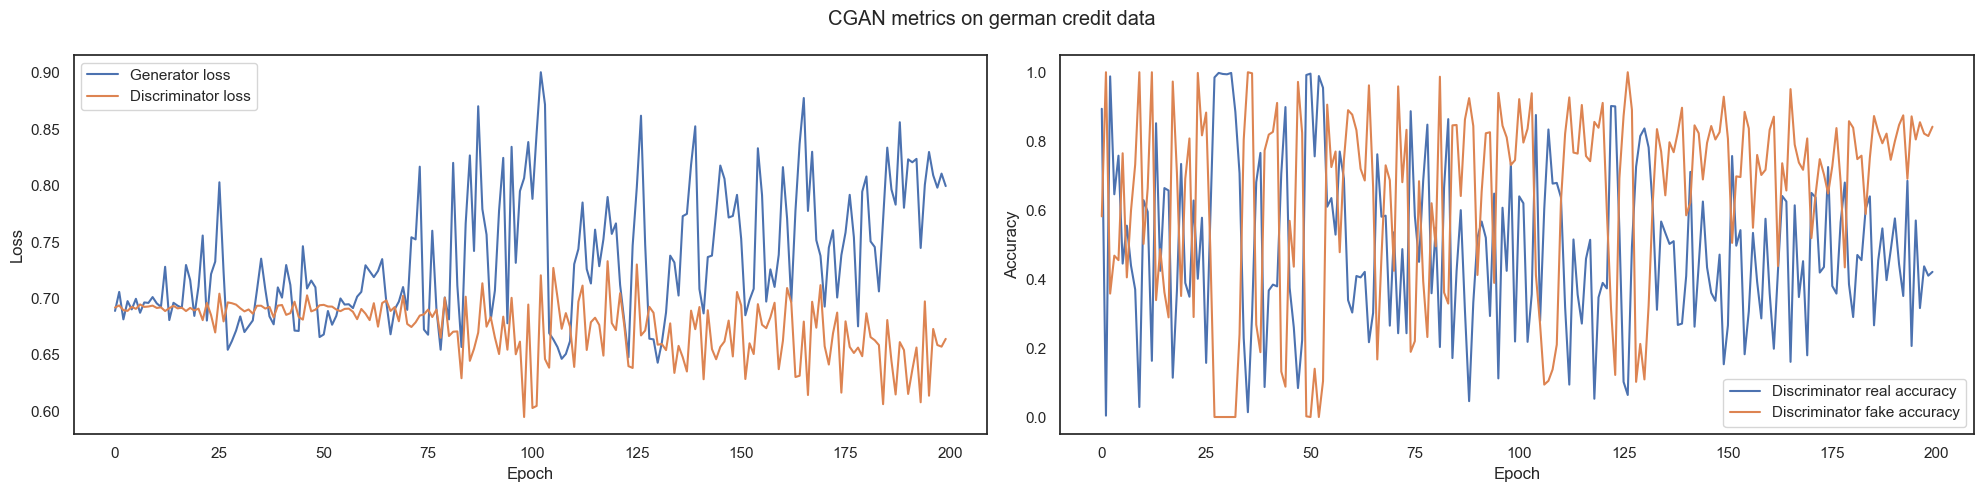

In [23]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on german credit data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [24]:
# Define number of samples to generate
num_samples = g_credit_X.shape[0]

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat([random_latent_vectors, g_credit_y], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, g_credit_y], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_g_credit_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_labels.numpy(), columns=clean_g_credit_df.columns
)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

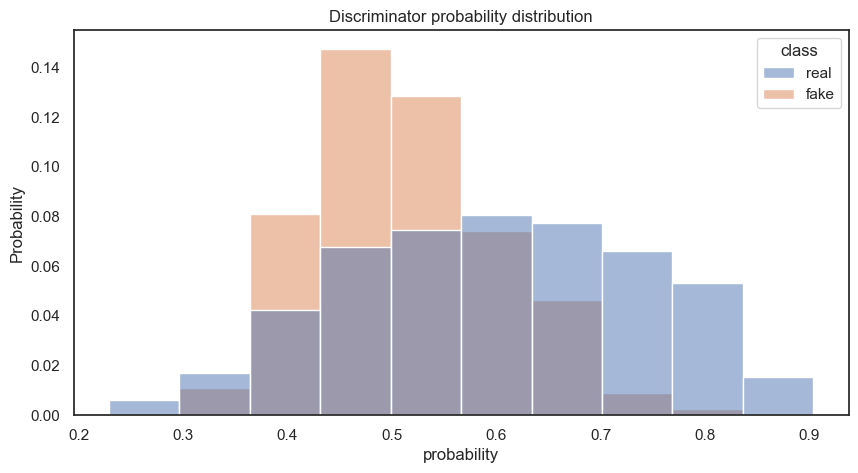

In [25]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [26]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 518


1       2    3    4          5    6    7      8    9    10  ...    12  \
0   A14 34.0370  A32  A43 1,242.1211  A61  A71 1.0000  A93  A101  ...  A121   
5   A14 35.4389  A32  A43 2,224.1121  A61  A71 4.0000  A93  A101  ...  A121   
6   A12 31.0095  A32  A43 1,794.7522  A61  A73 4.0000  A92  A101  ...  A121   
7   A12 28.1597  A34  A42 1,349.1792  A61  A75 4.0000  A92  A101  ...  A123   
11  A11 42.4957  A32  A43   564.5881  A61  A73 3.0000  A92  A101  ...  A123   
17  A12 25.2022  A32  A43 1,400.4589  A61  A75 4.0000  A92  A101  ...  A121   
18  A14 32.8330  A32  A43 2,349.6453  A61  A73 4.0000  A93  A101  ...  A123   
19  A14 31.9914  A32  A43 1,907.0240  A61  A73 2.0000  A92  A101  ...  A121   
20  A12 27.6635  A32  A40 2,472.0881  A61  A75 4.0000  A93  A101  ...  A121   
23  A12 42.1690  A32  A43 2,300.7590  A61  A73 2.0000  A92  A101  ...  A123   

        13    14    15     16    17     18    19    20 class  
0  35.4232  A143  A152 1.0000  A172 2.0000  A191  A201     1  
5  46.3218  A143  A152 1.0000  A172 2.0000  A191  A201     1  
6  29.2592  A143  A152 1.0000  A173 1.0000  A191  A201     1  
7  21.0083  A143  A152 2.0000  A173 1.0000  A192  A201     1  
11 20.4260  A143  A152 1.0000  A172 1.0000  A191  A201     2  
17 29.9867  A143  A152 1.0000  A173 1.0000  A192  A201     1  
18 35.7156  A143  A152 1.0000  A172 1.0000  A191  A201     2  
19 25.5330  A143  A152 1.0000  A173 1.0000  A191  A201     1  
20 36.5754  A143  A152 1.0000  A173 1.0000  A192  A201     1  
23 25.2966  A143  A152 1.0000  A173 1.0000  A191  A201     1  

[10 rows x 21 columns]

In [27]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 482


1       2    3    4          5    6    7      8    9    10  ...    12  \
1   A12 39.8594  A32  A42 2,370.1929  A61  A73 4.0000  A93  A101  ...  A123   
2   A12 34.0539  A32  A42 3,458.8093  A65  A75 4.0000  A93  A101  ...  A123   
3   A14 27.1145  A34  A43 1,825.3477  A61  A75 4.0000  A93  A101  ...  A121   
4   A12 21.7907  A32  A40 2,998.5510  A61  A75 4.0000  A93  A101  ...  A124   
8   A12 33.8869  A32  A43 2,198.3096  A61  A74 4.0000  A92  A101  ...  A121   
9   A12 29.4352  A34  A42 1,656.6167  A61  A75 4.0000  A93  A101  ...  A123   
10  A12 29.6995  A34  A42 3,754.8108  A61  A75 4.0000  A93  A101  ...  A123   
12  A12 33.1941  A32  A43 4,033.4189  A61  A75 4.0000  A93  A101  ...  A123   
13  A14 28.3903  A34  A43 2,685.4216  A61  A75 4.0000  A93  A101  ...  A123   
14  A14 48.0702  A32  A42   751.5242  A61  A73 2.0000  A92  A101  ...  A123   

        13    14    15     16    17     18    19    20 class  
1  19.8015  A143  A152 1.0000  A173 1.0000  A191  A201     2  
2  24.8680  A143  A152 2.0000  A173 1.0000  A192  A201     1  
3  43.4769  A143  A152 2.0000  A173 2.0000  A192  A201     1  
4  36.3925  A143  A152 1.0000  A174 1.0000  A192  A201     2  
8  30.6125  A143  A151 1.0000  A173 1.0000  A191  A201     1  
9  29.5631  A143  A152 2.0000  A173 1.0000  A192  A201     2  
10 28.2542  A143  A152 2.0000  A173 2.0000  A192  A201     2  
12 31.3572  A143  A152 1.0000  A173 1.0000  A191  A201     1  
13 33.7735  A143  A152 2.0000  A173 2.0000  A191  A201     2  
14 19.4957  A143  A152 1.0000  A173 1.0000  A191  A201     1  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

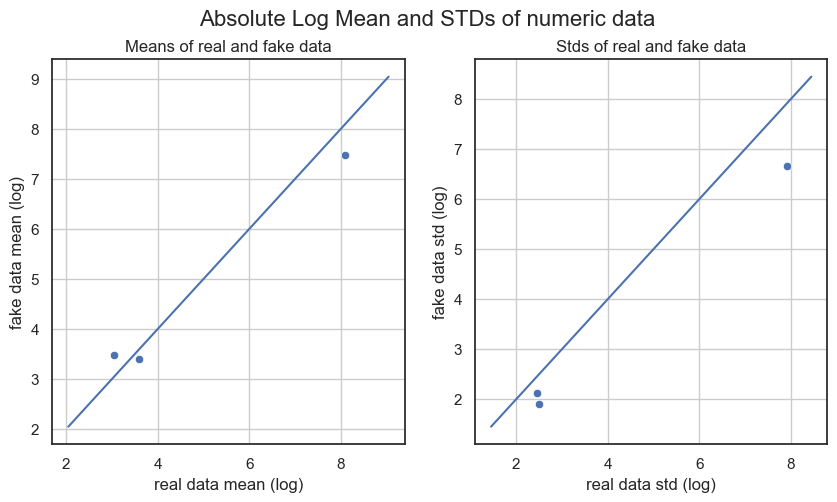

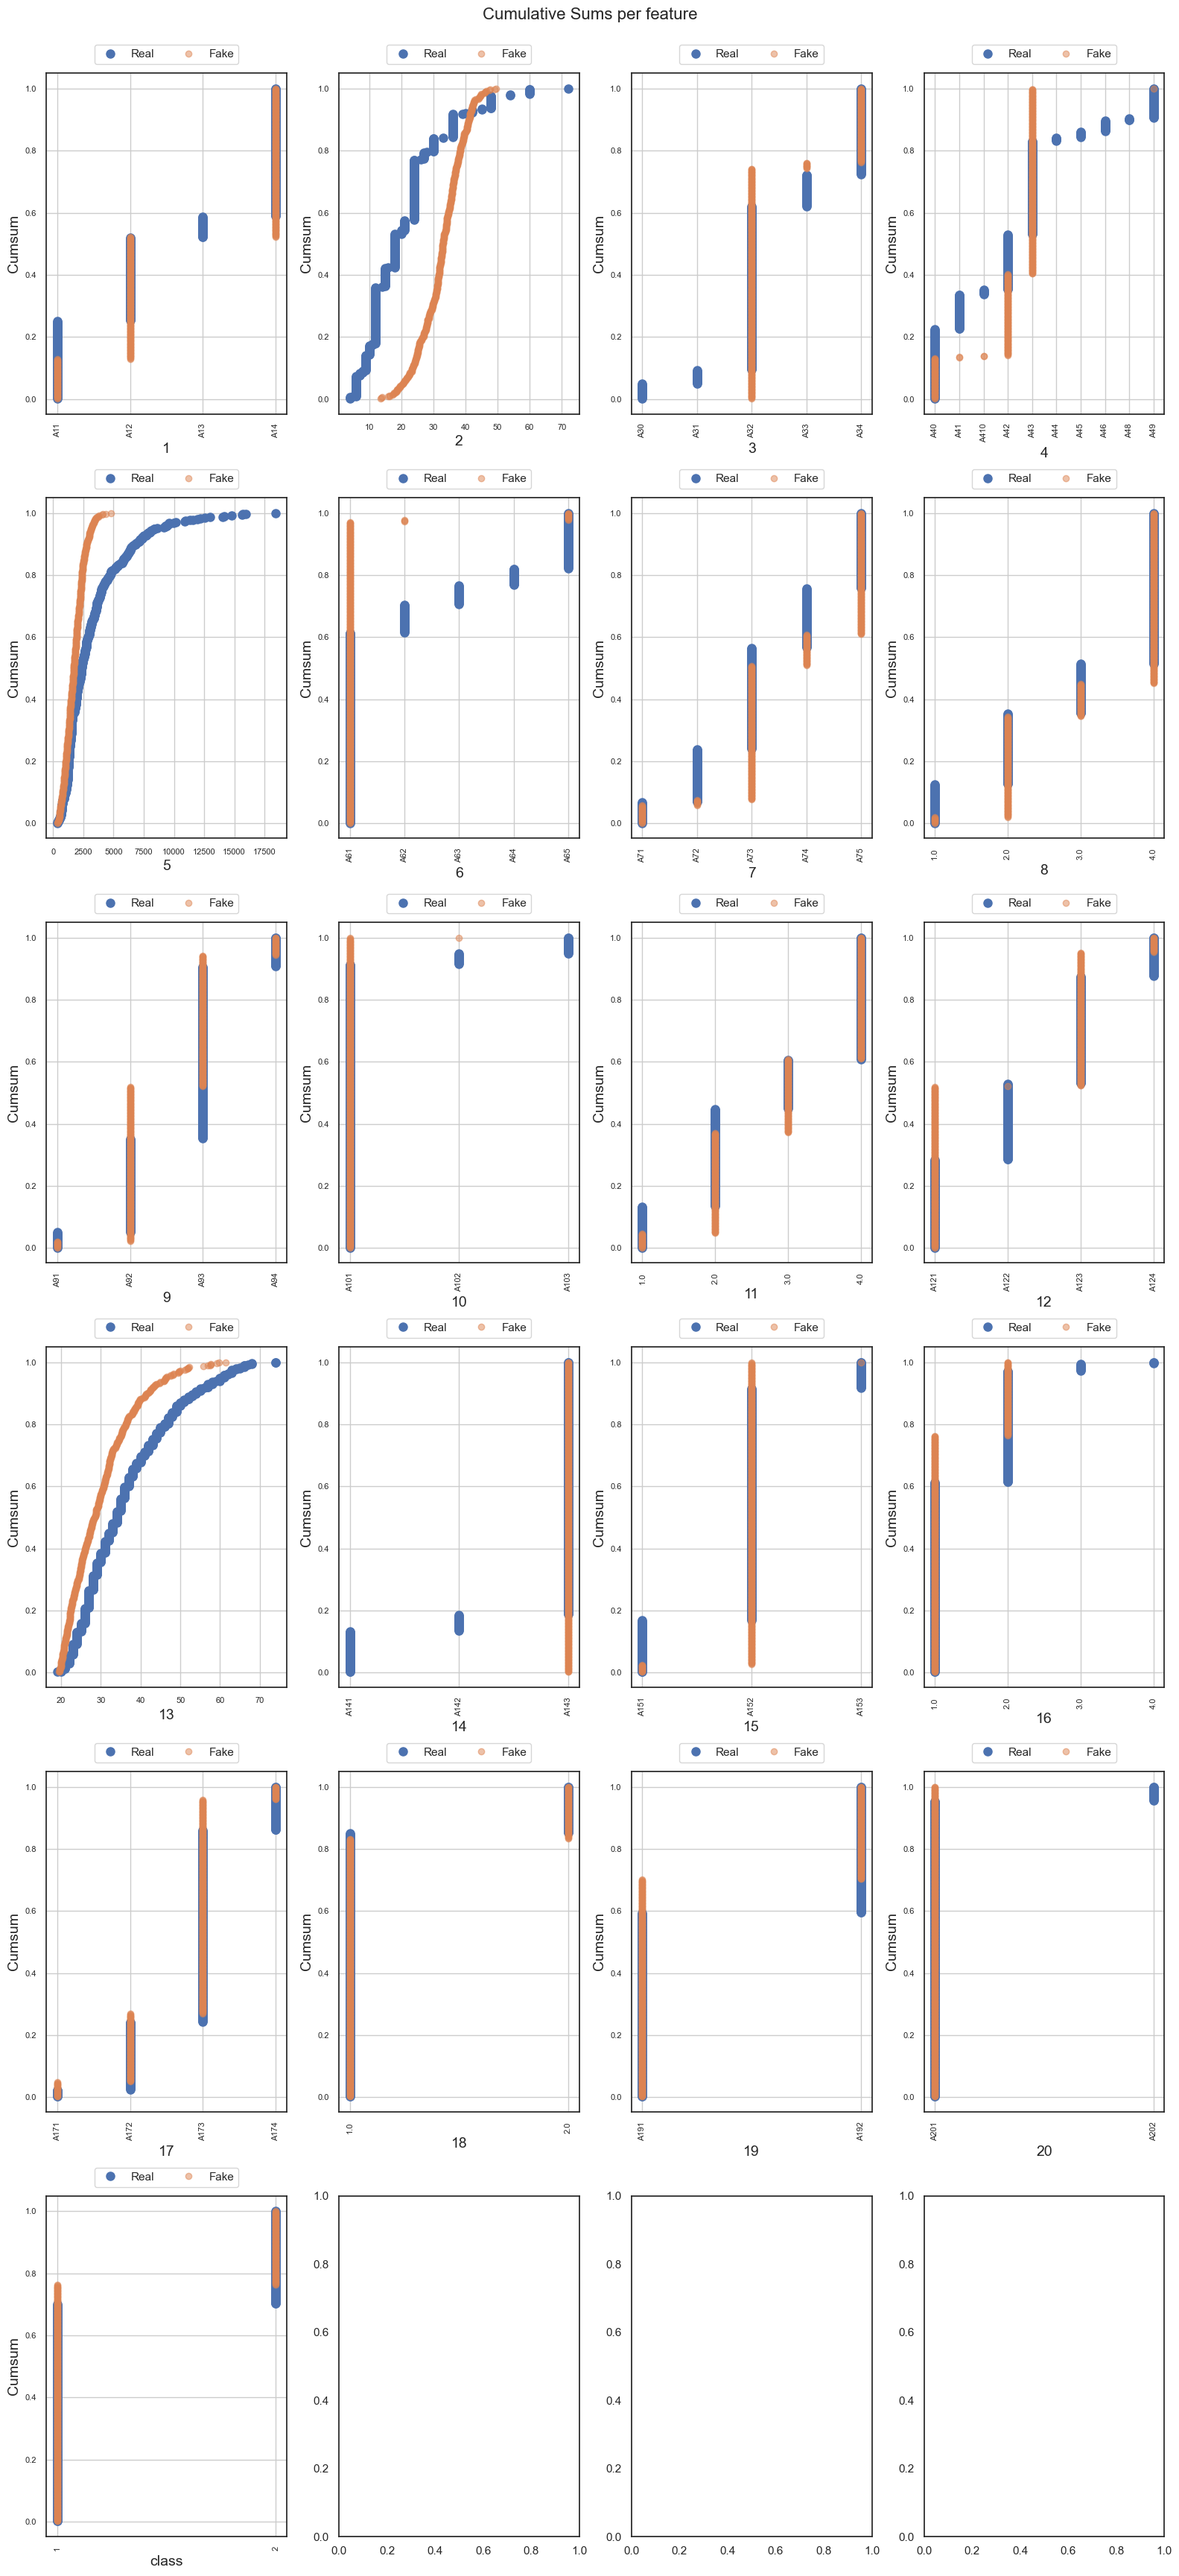

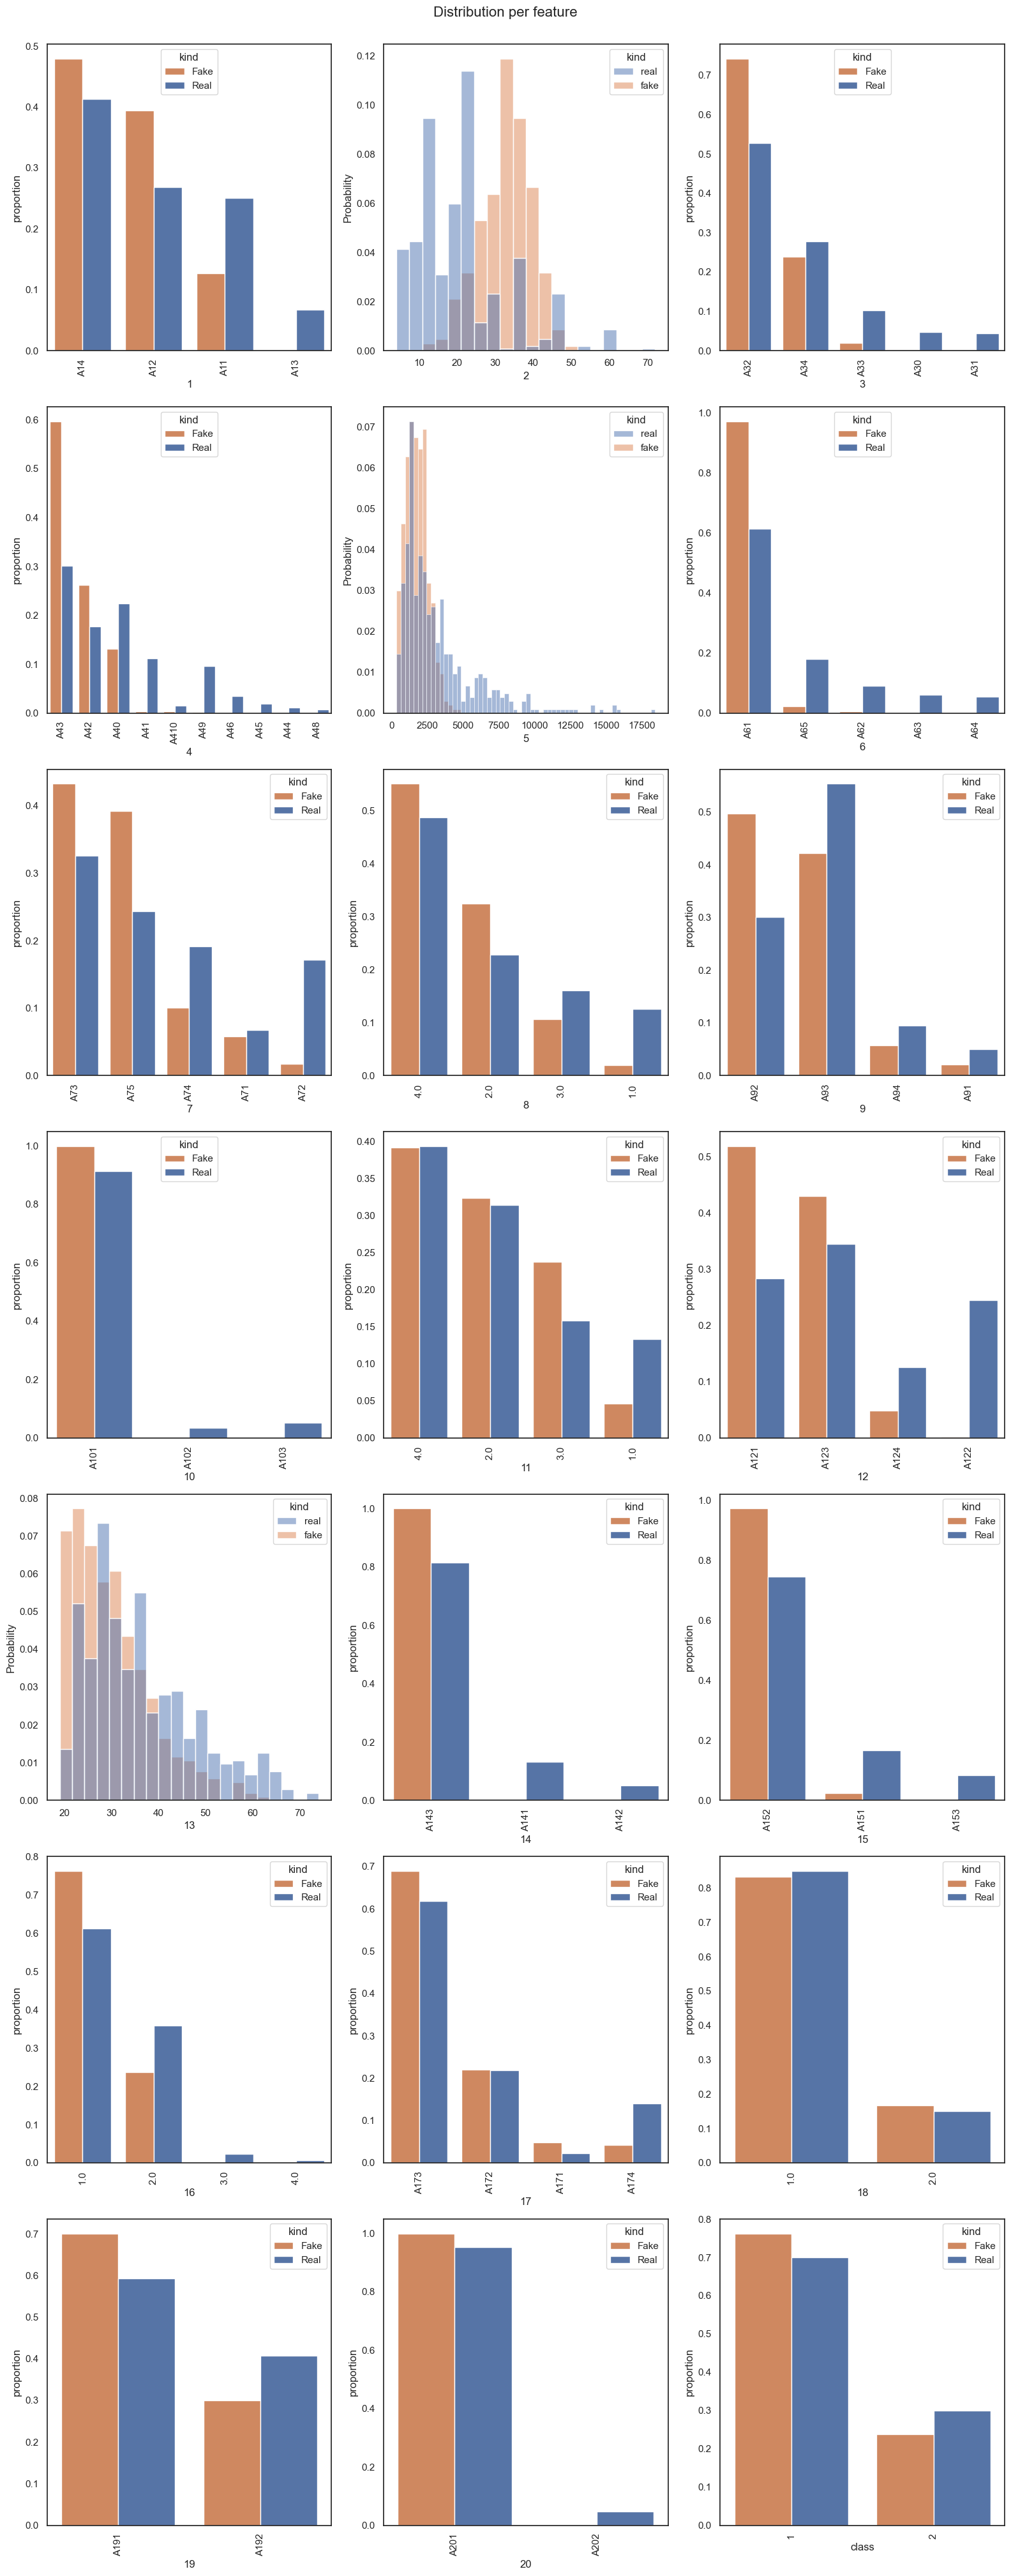

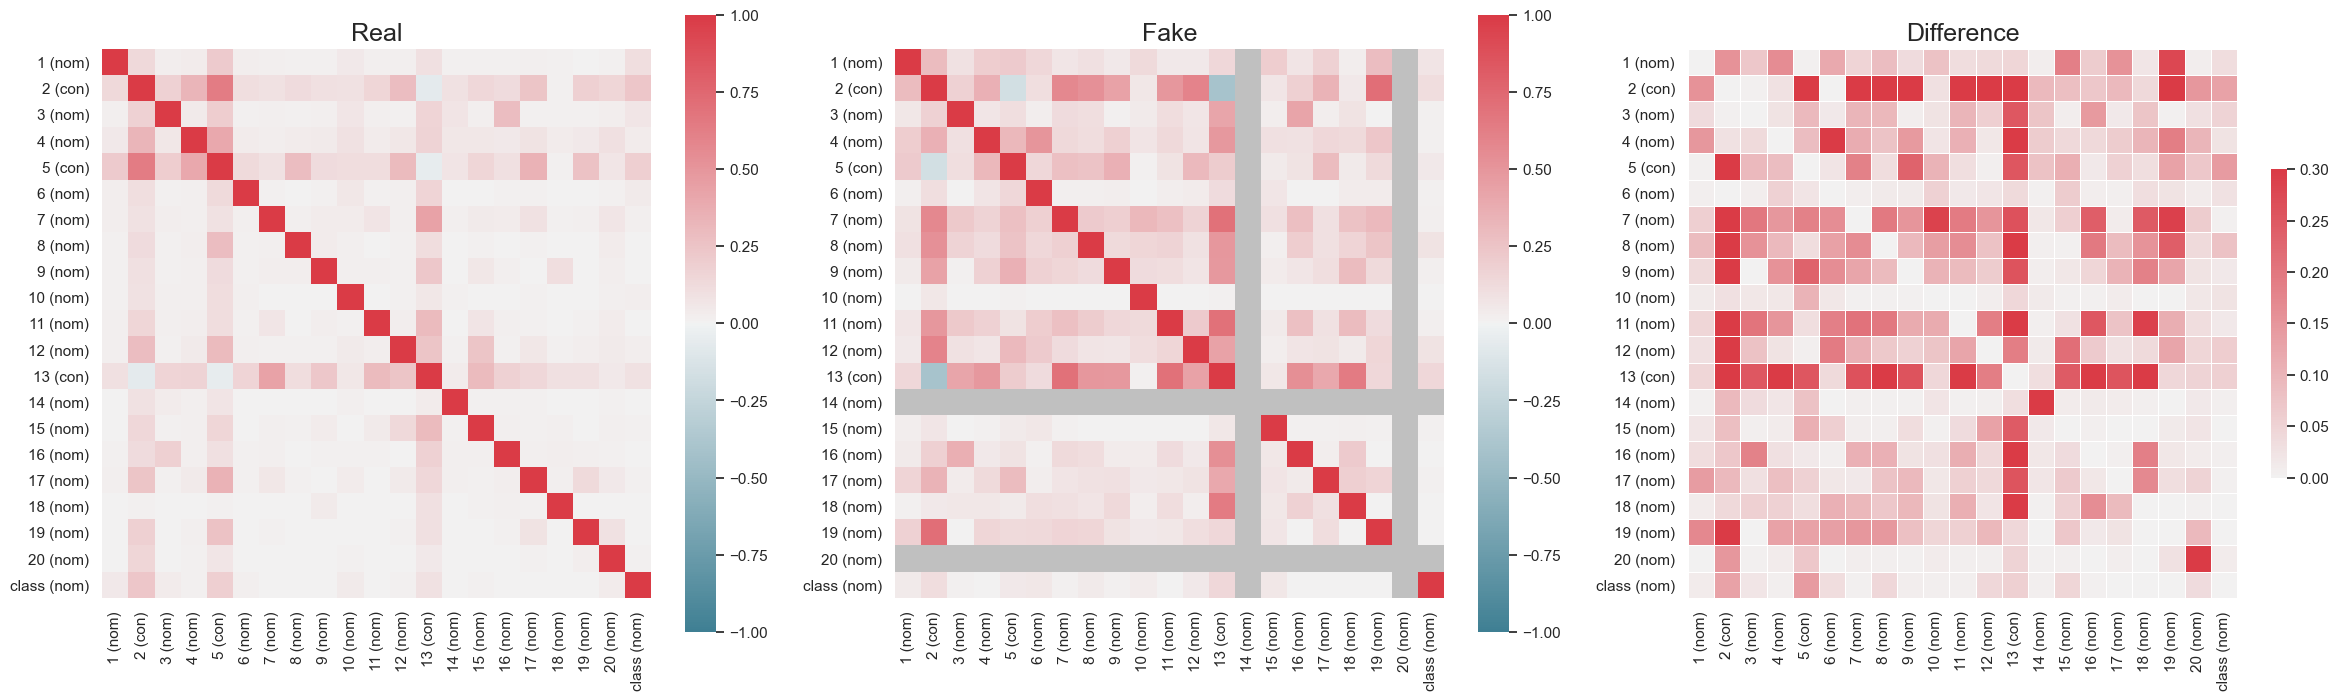

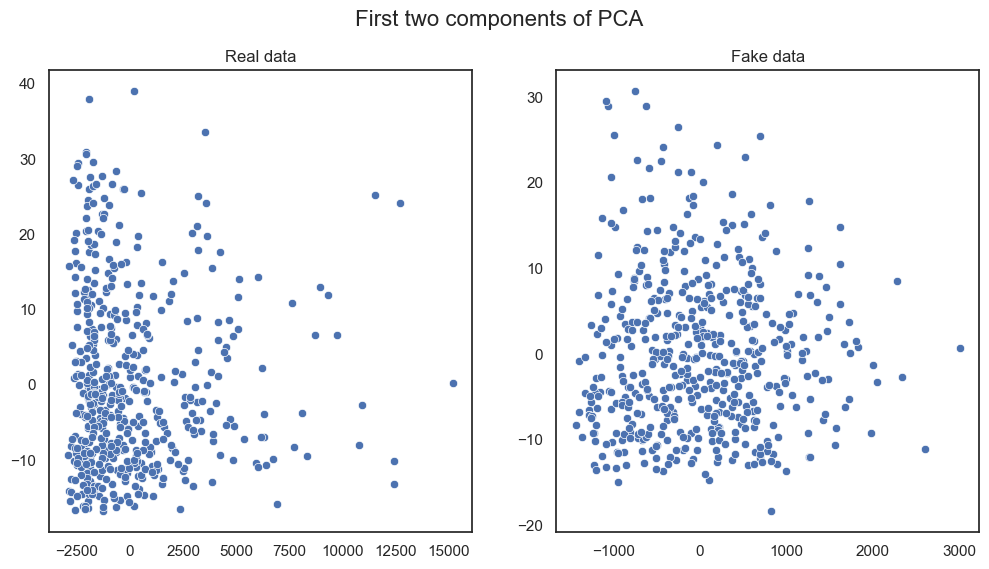


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6923   0.7692              0.5294
DecisionTreeClassifier_real   0.6058   0.5962              0.3775
LogisticRegression_fake       0.5385   0.8462              0.3333
LogisticRegression_real       0.7885   0.6923              0.6508
MLPClassifier_fake            0.4038   0.5577              0.6508
MLPClassifier_real            0.4904   0.5096              0.8246
RandomForestClassifier_fake   0.6442   0.7981              0.5072
RandomForestClassifier_real   0.7308   0.6923              0.6250

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    3.6321
nearest neighbor std                     0.4216

Miscellaneous results:
                                  Result
Column Cor

In [28]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df, fooled,
    cat_cols=g_credit_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

### ***Part 2 – Generative Adversarial Networks with a twist***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [29]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(
              data_dim, activation="tanh", kernel_initializer=WEIGHT_INIT
          )
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, activation="sigmoid", kernel_initializer=WEIGHT_INIT)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(
      self, generator: Model, discriminator: Model, black_box: Any,
      latent_dim: int
  ):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator
    self.black_box = black_box

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.c_bce_metric = metrics.BinaryAccuracy()
    self.y_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.c_bce_metric,
        self.y_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile(run_eagerly=True)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(
      self, confidence_data: Tuple[tf.Tensor, tf.Tensor]
  ) -> Dict[str, float]:
    """Method to apply Training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack confidence score
    c, c = confidence_data

    # Get data size
    data_size = tf.shape(c)[0]

    # Sample random points in the latent space for the generator
    # and concatenate a random confidence score.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_c, training=True)

      # Get classification confidence score
      y = np.expand_dims(
          self.black_box.predict_proba(fake_records.numpy())[:, 1], axis=1
      )

      # concatenate the classification confidence score and random confidence
      # score to fake records
      fake_records_c = tf.concat([fake_records, c], axis=1)
      fake_records_y = tf.concat([fake_records, y], axis=1)

      # Get discriminator prediction
      fake_records_c_predictions = self.discriminator(fake_records_c)
      fake_records_y_predictions = self.discriminator(fake_records_y)

      # Calculate c loss
      d_c_loss = self.loss_fn(
          tf.zeros((data_size, 1)), fake_records_c_predictions
      )

      # Calculate y loss
      d_y_loss = self.loss_fn(
          tf.ones((data_size, 1)), fake_records_y_predictions
      )

      # Calculate discriminator and generator loss
      d_loss = (d_c_loss + d_y_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_records_c_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.c_bce_metric.update_state(
        tf.zeros((data_size, 1)), fake_records_c_predictions
    )
    self.y_bce_metric.update_state(
        tf.ones((data_size, 1)), fake_records_y_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_y_acc": self.y_bce_metric.result(),
        "d_c_acc": self.c_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a RandomForest on the diabetes data:

In [30]:
# Split data to train-test sets
diabetes_x_train, diabetes_x_test, diabetes_y_train, diabetes_y_test = (
    train_test_split(
        diabetes_X.to_numpy(), diabetes_y.to_numpy(), test_size=TEST_SIZE,
        random_state=SEED
    )
)

# Define grid search parameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 4, 6],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 3, 4]
}

# Create grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED), param_grid,
    cv=StratifiedKFold(n_splits=5)
)

# Fit grid search
grid_search.fit(diabetes_x_train, diabetes_y_train.ravel())

# Print best score and parameters and test score
print(f"Best score {grid_search.best_score_}:")
print(f"Best parameters: {grid_search.best_params_}")
print(
    (
        f"Test score: "
        f"{grid_search.best_estimator_.score(diabetes_x_test, diabetes_y_test)}"
    )
)

Best score 0.772724125995154:
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Test score: 0.7359307359307359


Next, let's plot confidence score distribution:

('Min: 0.007', 'Max: 0.882', 'Mean: 0.373', 'Median: 0.353')


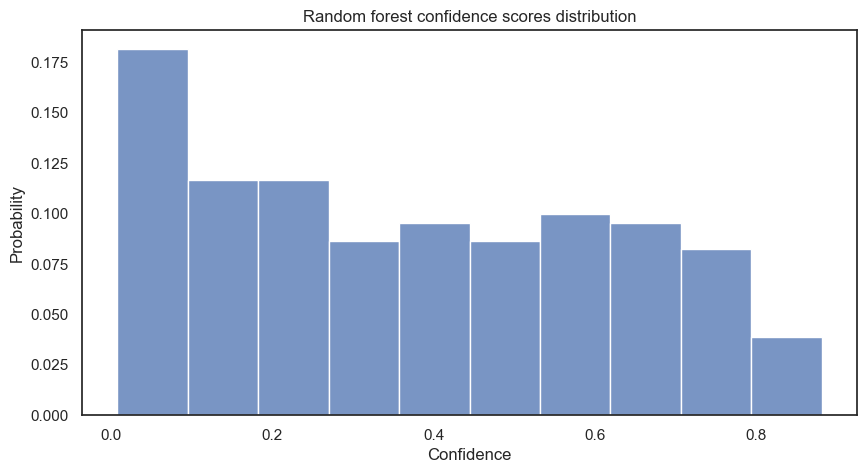

In [31]:
# Create confidence scores
confidence_scores = pd.Series(
    grid_search.best_estimator_.predict_proba(diabetes_x_test)[:, 1]
)

# Print stats
print(
    (
        f"Min:{confidence_scores.min(): .3f}",
        f"Max:{confidence_scores.max(): .3f}",
        f"Mean:{confidence_scores.mean(): .3f}",
        f"Median:{confidence_scores.median(): .3f}"
    )
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot confidence scores distribution
sns.histplot(confidence_scores, bins=10, stat="probability", ax=ax)

# Show plot
ax.set_xlabel("Confidence")
plt.title("Random forest confidence scores distribution")
plt.show()

Next, let's train the best random forest on all the dataset:

In [32]:
clf = RandomForestClassifier(random_state=SEED, **grid_search.best_params_)
clf = clf.fit(diabetes_X.to_numpy(), diabetes_y.to_numpy().ravel())

Next, let's train a conditional GAN on the diabetes data:

In [33]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
c_dim = 1

# Sample confidence scores
c = tf.random.uniform(shape=(1000, c_dim), minval=0, maxval=1)

# Create CGAN
gen = make_generator(latent_dim + c_dim, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + c_dim)
cgan = CGAN(gen, dis, clf ,latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

# Train CGAN
history = cgan.fit(
    c, c, epochs=DIABETES_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/1500
32/32 [==============================] - 2s 64ms/step - g_loss: 0.6931 - d_loss: 0.6931 - d_c_acc: 0.4798 - d_y_acc: 0.5696
Epoch 2/1500
32/32 [==============================] - 2s 63ms/step - g_loss: 0.6932 - d_loss: 0.6930 - d_c_acc: 0.5319 - d_y_acc: 0.7281
Epoch 3/1500
32/32 [==============================] - 2s 63ms/step - g_loss: 0.6949 - d_loss: 0.6889 - d_c_acc: 0.4655 - d_y_acc: 0.9354
Epoch 4/1500
32/32 [==============================] - 2s 65ms/step - g_loss: 0.7114 - d_loss: 0.6672 - d_c_acc: 0.4565 - d_y_acc: 1.0000
Epoch 5/1500
32/32 [==============================] - 2s 64ms/step - g_loss: 0.8077 - d_loss: 0.6269 - d_c_acc: 0.5085 - d_y_acc: 1.0000
Epoch 6/1500
32/32 [==============================] - 2s 70ms/step - g_loss: 0.9738 - d_loss: 0.5888 - d_c_acc: 0.5214 - d_y_acc: 1.0000
Epoch 7/1500
32/32 [==============================] - 2s 62ms/step - g_loss: 1.1443 - d_loss: 0.5704 - d_c_acc: 0.5040 - d_y_acc: 1.0000
Epoch 8/1500
32/32 [=====================

Next, let's plot training metrics:

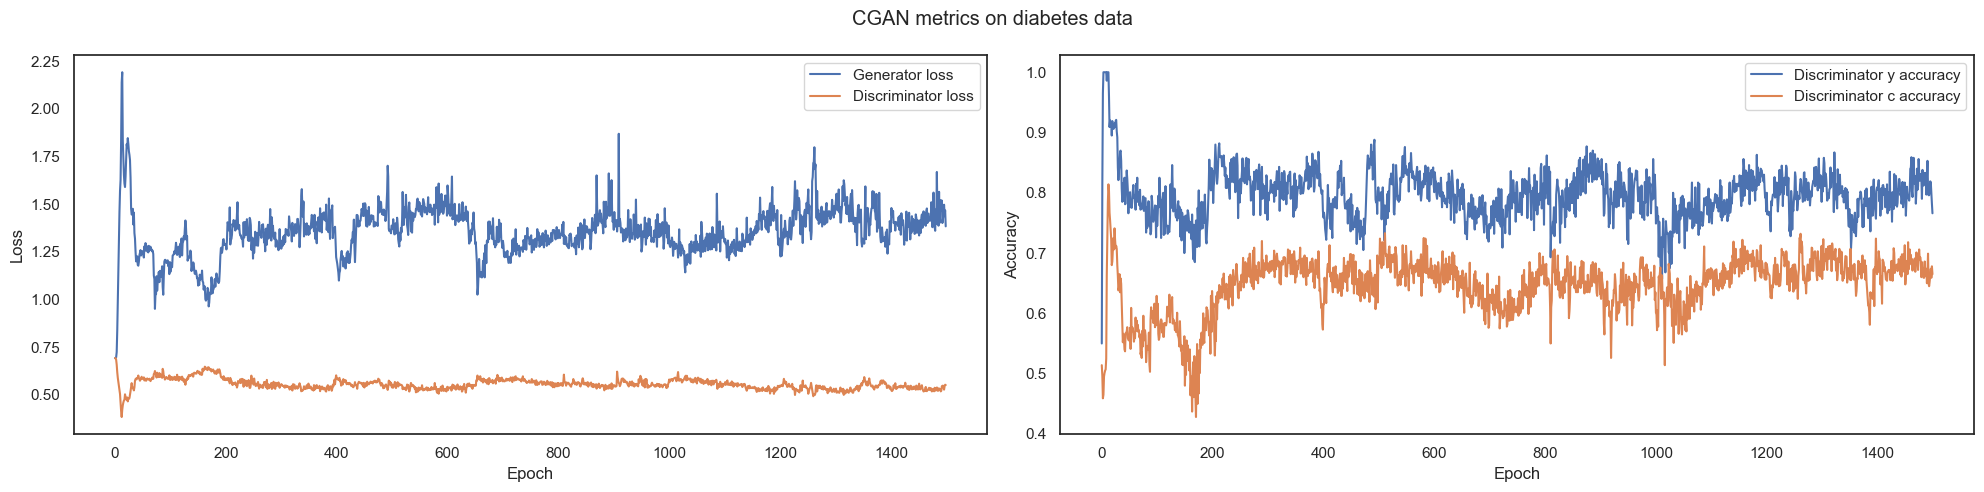

In [34]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_y_acc"], label="Discriminator y accuracy")
ax[1].plot(history.history["d_c_acc"], label="Discriminator c accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [35]:
# Define number of samples to generate
num_samples = 1000

# Sample random points in the latent space for the generator
# and concatenate the labels.
c = tf.random.uniform(shape=(num_samples, 1), maxval=1, minval=0)
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_c)
fake_records_and_c = tf.concat([fake_records, c], axis=1)

# Get discriminator predictions for fake and real dataset
d_c_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_c),
    columns=["discriminator_probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_c.numpy(), columns=clean_diabetes_df.columns
)

# Create class from confidence score
fake_clean_diabetes_df["class"] = fake_clean_diabetes_df["class"].apply(np.rint)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

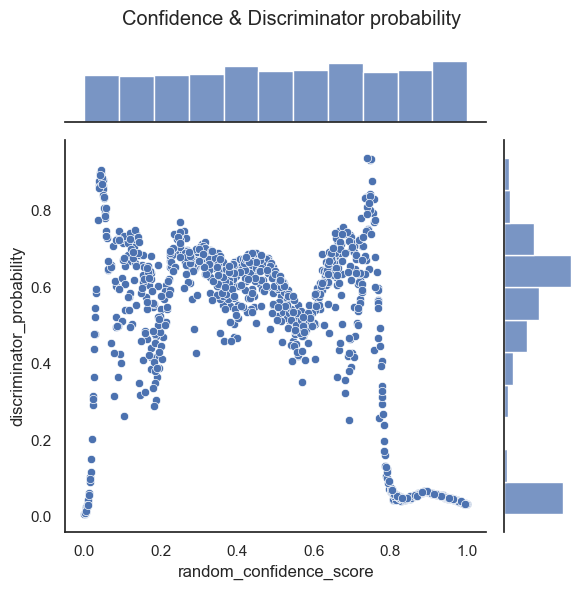

In [36]:
# Add confidence to data frame
d_c_predictions["random_confidence_score"] = c.numpy()

# Plot confidence over discriminator probability
p = sns.jointplot(
    data=d_c_predictions, x="random_confidence_score",
    y="discriminator_probability",
    height=6
)

# Show plot
p.fig.suptitle("Confidence & Discriminator probability")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.90)
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [37]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_c_predictions["discriminator_probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 619


preg     plas   pres   skin    insu    mass   pedi     age  \
1  0.1152 150.9592 0.0625 0.0795 14.4329 48.5019 0.0818 21.0405   
3  0.0940 144.4347 0.2955 0.0421  3.6131 46.5244 0.0885 21.0294   
4  0.0243 125.9804 2.1682 0.0162  0.5981 41.4291 0.1126 21.0370   
5  0.0000  41.0059 5.9474 0.0009  0.0000 28.7363 0.0789 21.0000   
7  0.2936 165.5863 0.0023 0.0931 39.7134 49.3055 0.0789 21.0326   
10 0.0135 125.6180 1.7918 0.0076  0.2895 41.7127 0.1075 21.0190   
12 0.0261 128.6202 1.8406 0.0144  0.4689 42.1973 0.1070 21.0253   
13 0.1188 152.8881 0.0645 0.0485  6.8417 48.4245 0.0815 21.0258   
15 0.0017 104.6641 6.2027 0.0026  0.0030 36.6745 0.1469 21.0049   
17 0.0342 135.9813 0.5248 0.0163  1.7283 45.6673 0.0899 21.0237   

              class  
1   tested_positive  
3   tested_positive  
4   tested_positive  
5   tested_negative  
7   tested_positive  
10  tested_positive  
12  tested_positive  
13  tested_positive  
15  tested_negative  
17  tested_positive

In [38]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[
    d_c_predictions["discriminator_probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 381


preg     plas   pres   skin   insu    mass   pedi     age  \
0  17.0000 199.0000 0.0000 0.0001 0.0000 52.8738 0.0780 21.0000   
2  17.0000 198.9998 0.0000 0.0001 0.0010 51.6415 0.0780 21.0000   
6  17.0000 198.9998 0.0000 0.0005 0.0013 51.3865 0.0780 21.0000   
8  17.0000 198.9985 0.0000 0.0020 0.0182 50.2810 0.0780 21.0002   
9  17.0000 198.9998 0.0000 0.0006 0.0005 51.4443 0.0780 21.0000   
11 17.0000 198.9025 0.0000 0.0053 0.6809 50.4588 0.0780 21.0002   
14  0.0000  11.1790 2.0811 0.0000 0.0000 21.2366 0.0780 21.0000   
16  0.0004  84.4613 7.7901 0.0016 0.0000 31.9160 0.1158 21.0004   
20 17.0000 199.0000 0.0000 0.0003 0.0002 51.9598 0.0780 21.0000   
22 17.0000 198.9913 0.0000 0.0026 0.0502 49.7974 0.0780 21.0001   

              class  
0   tested_positive  
2   tested_positive  
6   tested_positive  
8   tested_positive  
9   tested_positive  
11  tested_positive  
14  tested_negative  
16  tested_negative  
20  tested_positive  
22  tested_positive

Lets evaluate the generated samples using table evaluator:

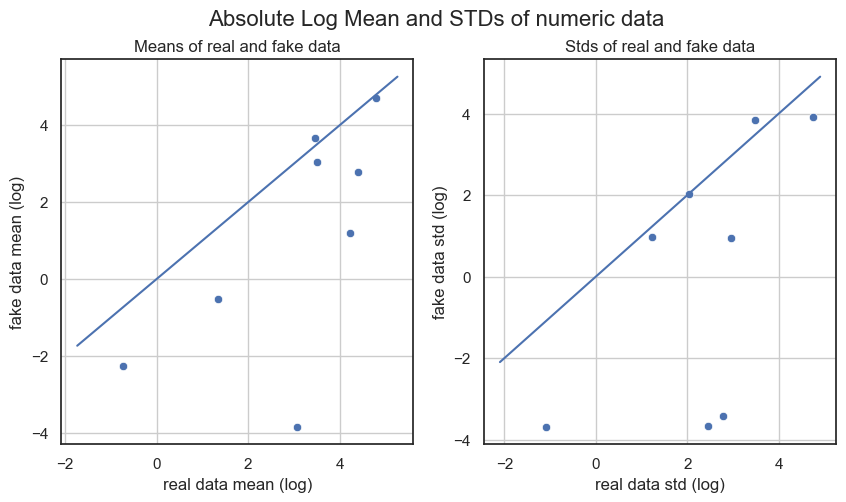

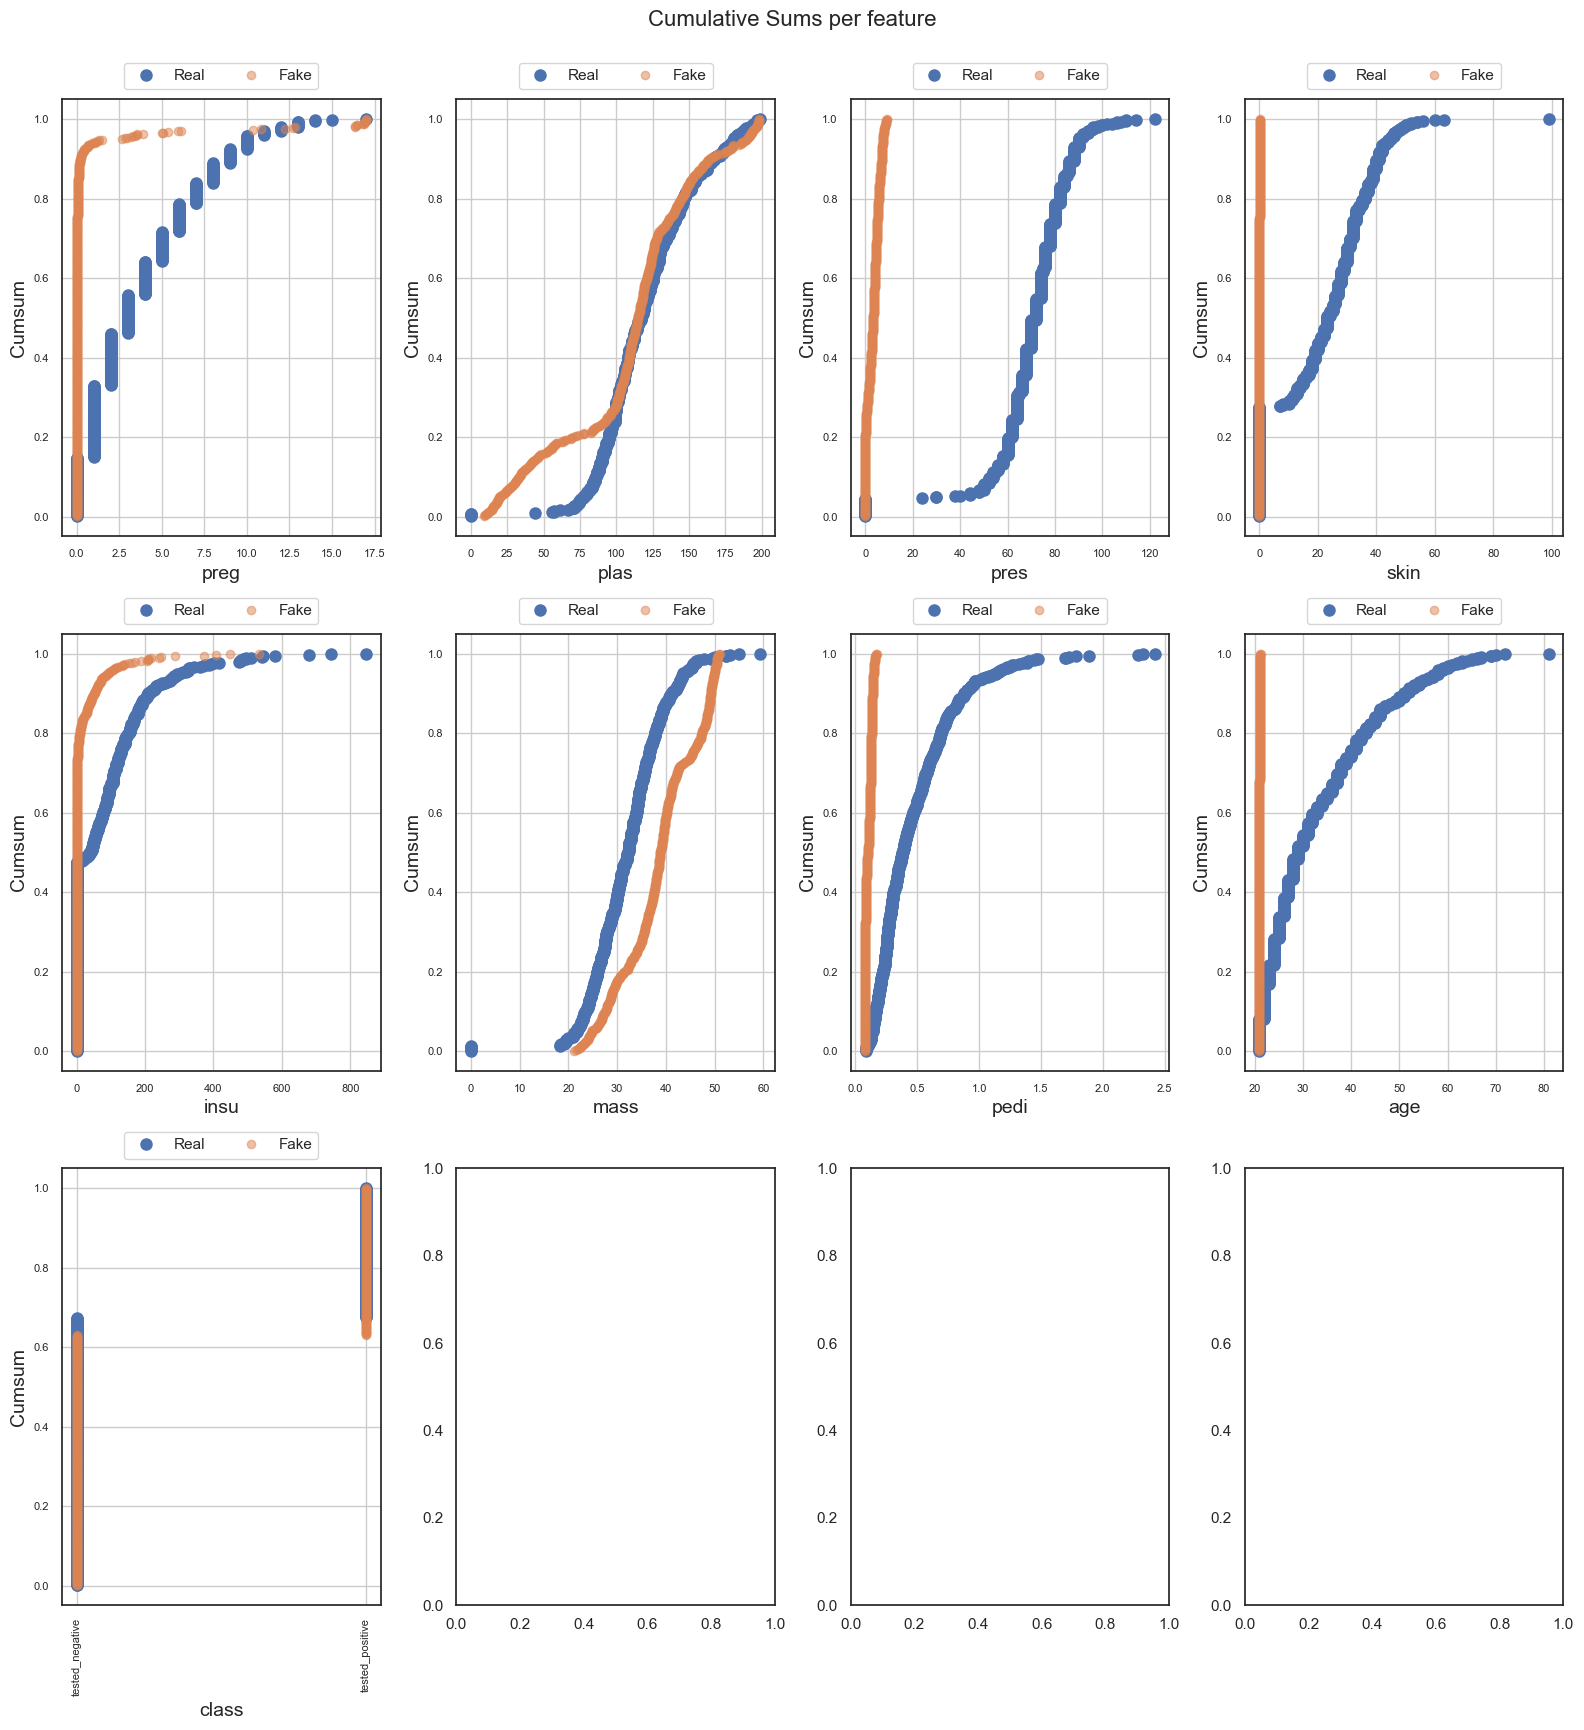

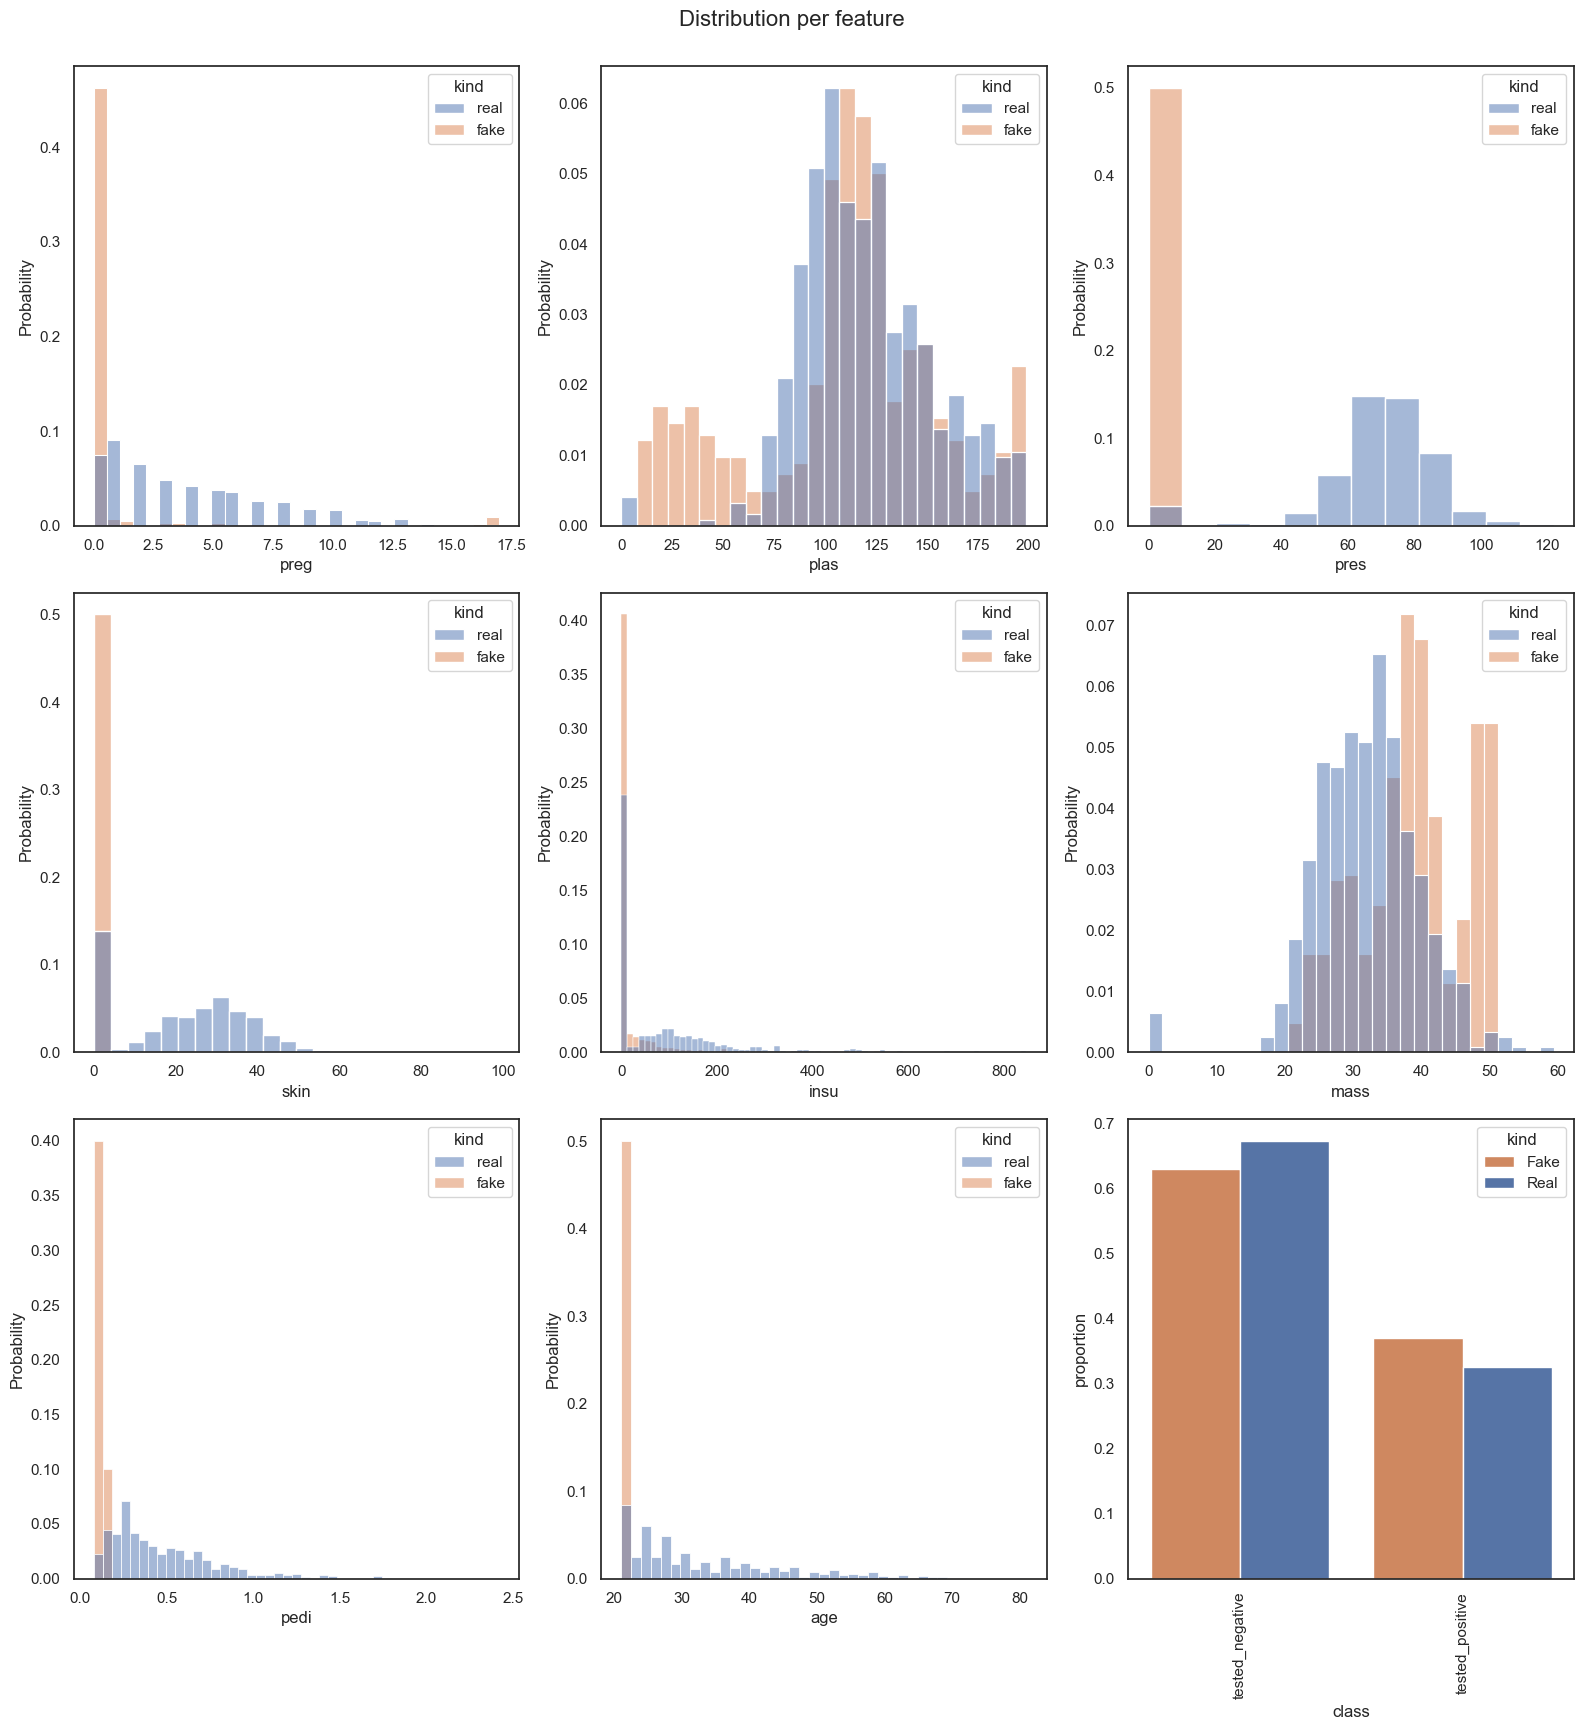

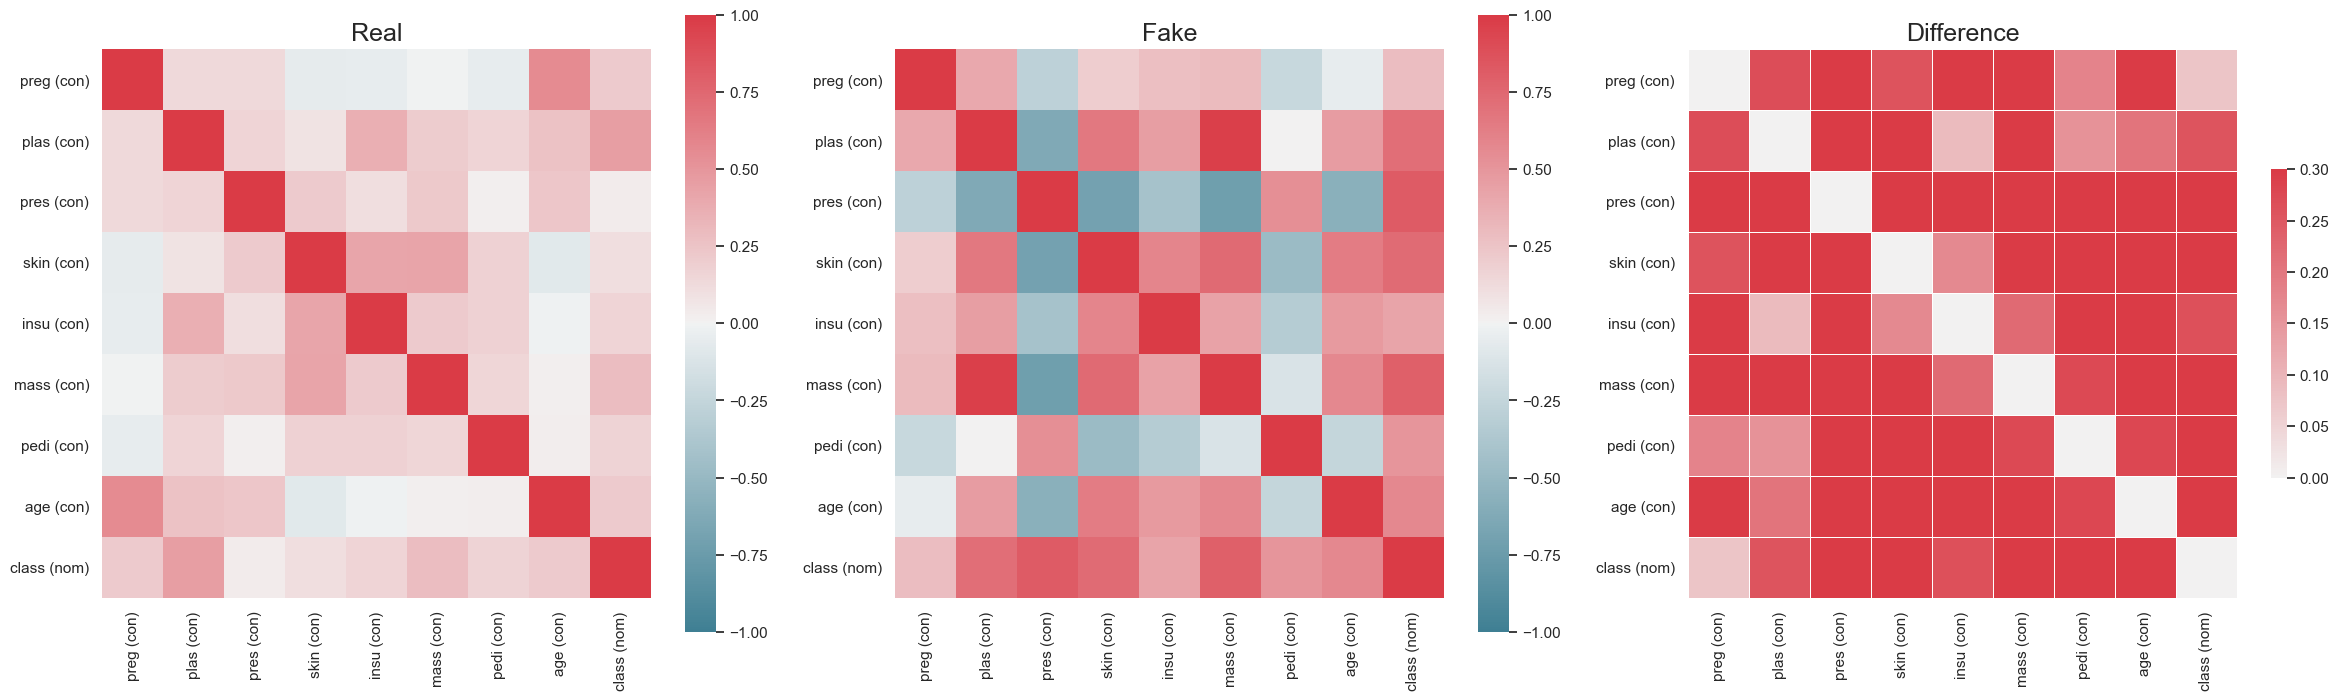

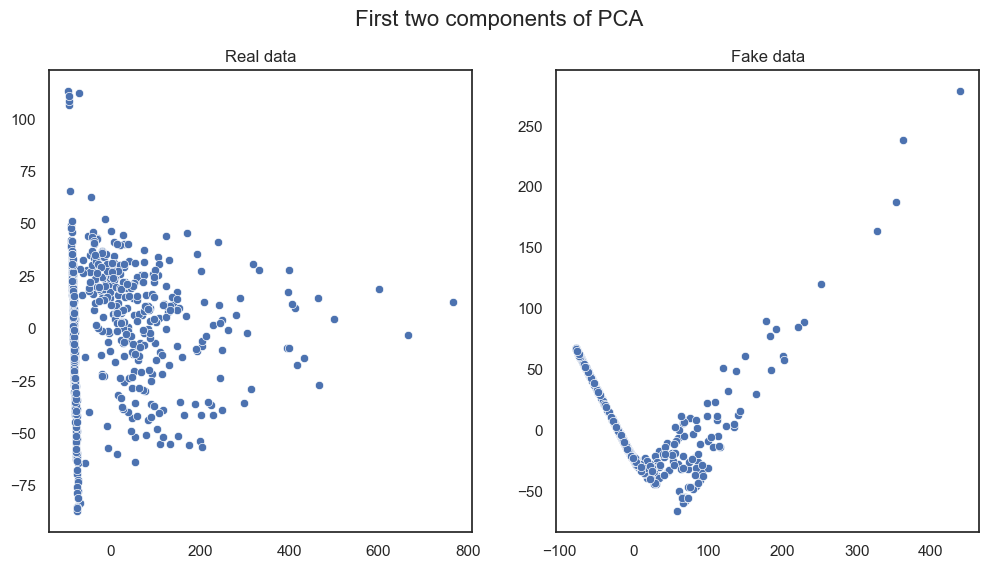


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5000   0.9758              0.3122
DecisionTreeClassifier_real   0.7339   0.7177              0.4762
LogisticRegression_fake       0.9597   0.9839              0.8931
LogisticRegression_real       0.8065   0.8226              0.8235
MLPClassifier_fake            0.5161   0.9516              0.3053
MLPClassifier_real            0.7016   0.5081              0.4091
RandomForestClassifier_fake   0.7097   0.9758              0.5215
RandomForestClassifier_real   0.7500   0.7661              0.5897

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    2.2533
nearest neighbor std                     0.7588

Miscellaneous results:
                                  Result
Column Cor

In [39]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df,
    fake_diabetes_df[d_c_predictions["discriminator_probability"] > 0.5],
    cat_cols=diabetes_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's train a conditional GAN on the germen credit data:

In [40]:
# Split data to train-test sets
g_credit_x_train, g_credit_x_test, g_credit_y_train, g_credit_y_test = (
    train_test_split(
        g_credit_X.to_numpy(), g_credit_y.to_numpy(), test_size=TEST_SIZE,
        random_state=SEED
    )
)

# Define grid search parameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 4, 6],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 3, 4]
}

# Create grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED), param_grid,
    cv=StratifiedKFold(n_splits=5)
)

# Fit grid search
grid_search.fit(g_credit_x_train, g_credit_y_train.ravel())

# Print best score and parameters and test score
print(f"Best score {grid_search.best_score_}:")
print(f"Best parameters: {grid_search.best_params_}")
print(
    (
        f"Test score: "
        f"{grid_search.best_estimator_.score(g_credit_x_test, g_credit_y_test)}"
    )
)

Best score 0.7414285714285714:
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test score: 0.7366666666666667


Next, let's plot confidence score distribution:

('Min: 0.056', 'Max: 0.693', 'Mean: 0.294', 'Median: 0.279')


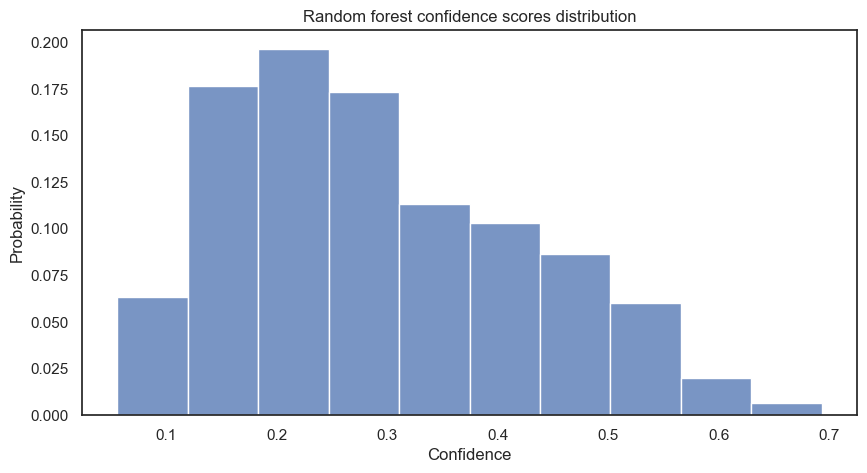

In [41]:
# Create confidence scores
confidence_scores = pd.Series(
    grid_search.best_estimator_.predict_proba(g_credit_x_test)[:, 1]
)

# Print stats
print(
    (
        f"Min:{confidence_scores.min(): .3f}",
        f"Max:{confidence_scores.max(): .3f}",
        f"Mean:{confidence_scores.mean(): .3f}",
        f"Median:{confidence_scores.median(): .3f}"
    )
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot confidence scores distribution
sns.histplot(confidence_scores, bins=10, stat="probability", ax=ax)

# Show plot
ax.set_xlabel("Confidence")
plt.title("Random forest confidence scores distribution")
plt.show()

Next, let's train the best random forest on all the dataset:

In [42]:
clf = RandomForestClassifier(random_state=SEED, **grid_search.best_params_)
clf = clf.fit(g_credit_X.to_numpy(), g_credit_y.to_numpy().ravel())

Next, let's train a conditional GAN on the diabetes data:

In [50]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
c_dim = 1

# Sample confidence scores
c = tf.random.uniform(shape=(1000, c_dim), minval=0, maxval=1)

# Create CGAN
gen = make_generator(latent_dim + c_dim, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + c_dim)
cgan = CGAN(gen, dis, clf ,latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

# Train CGAN
history = cgan.fit(
    c, c, epochs=DIABETES_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/1500
32/32 [==============================] - 2s 65ms/step - g_loss: 0.6931 - d_loss: 0.6931 - d_c_acc: 0.3488 - d_y_acc: 0.7325
Epoch 2/1500
32/32 [==============================] - 2s 62ms/step - g_loss: 0.6925 - d_loss: 0.6930 - d_c_acc: 0.4007 - d_y_acc: 0.6926
Epoch 3/1500
32/32 [==============================] - 2s 74ms/step - g_loss: 0.6930 - d_loss: 0.6931 - d_c_acc: 0.4334 - d_y_acc: 0.5916
Epoch 4/1500
32/32 [==============================] - 2s 65ms/step - g_loss: 0.6935 - d_loss: 0.6930 - d_c_acc: 0.4562 - d_y_acc: 0.4631
Epoch 5/1500
32/32 [==============================] - 2s 68ms/step - g_loss: 0.6923 - d_loss: 0.6926 - d_c_acc: 0.4073 - d_y_acc: 0.6242
Epoch 6/1500
32/32 [==============================] - 2s 62ms/step - g_loss: 0.6932 - d_loss: 0.6928 - d_c_acc: 0.3799 - d_y_acc: 0.7103
Epoch 7/1500
32/32 [==============================] - 2s 66ms/step - g_loss: 0.6984 - d_loss: 0.6927 - d_c_acc: 0.5771 - d_y_acc: 0.5172
Epoch 8/1500
32/32 [=====================

Next, let's plot training metrics:

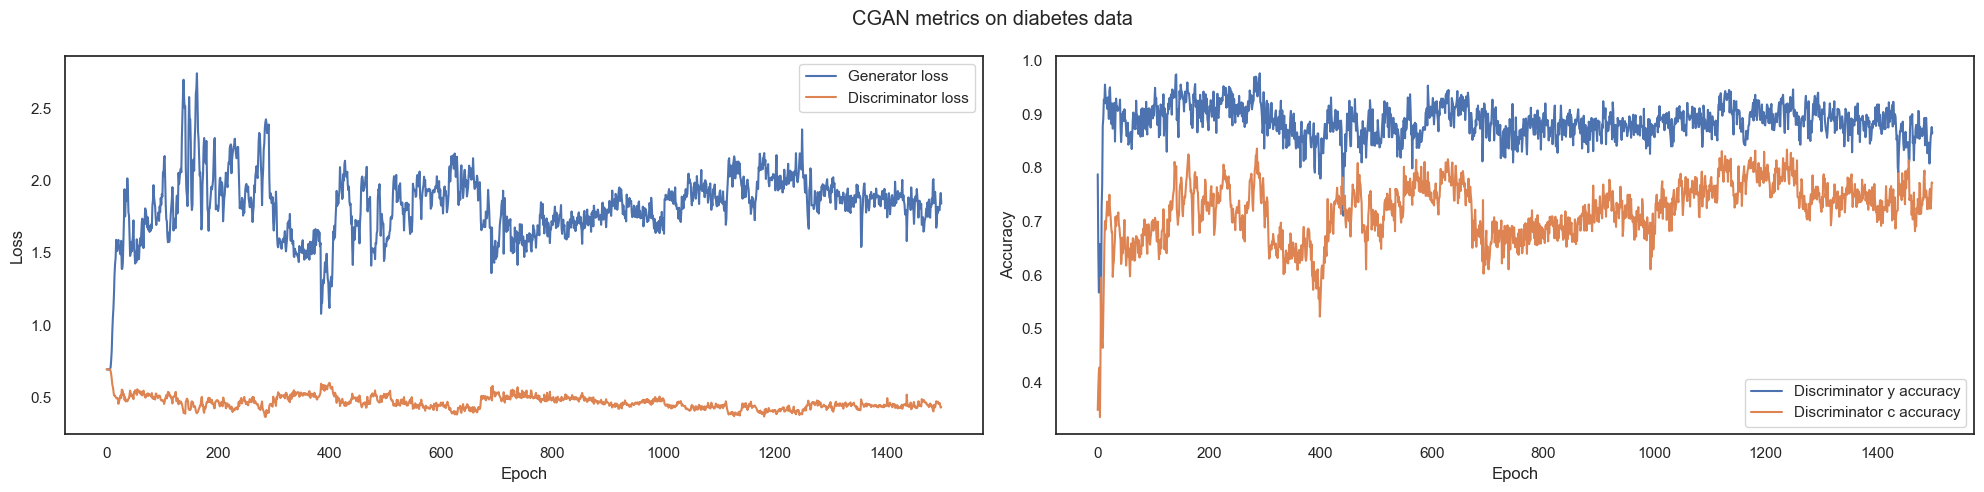

In [51]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_y_acc"], label="Discriminator y accuracy")
ax[1].plot(history.history["d_c_acc"], label="Discriminator c accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [52]:
# Define number of samples to generate
num_samples = 1000

# Sample random points in the latent space for the generator
# and concatenate the labels.
c = tf.random.uniform(shape=(num_samples, 1), maxval=1, minval=0)
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_c)
fake_records_and_c = tf.concat([fake_records, c], axis=1)

# Get discriminator predictions for fake and real dataset
d_c_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_c),
    columns=["discriminator_probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_c.numpy(), columns=clean_g_credit_df.columns
)

# Create class from confidence score
fake_clean_g_credit_df["class"] = fake_clean_g_credit_df["class"].apply(np.rint)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

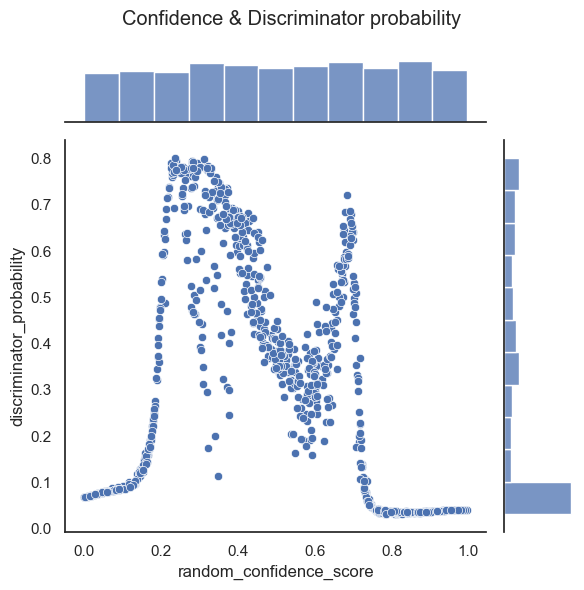

In [53]:
# Add confidence to data frame
d_c_predictions["random_confidence_score"] = c.numpy()

# Plot confidence over discriminator probability
p = sns.jointplot(
    data=d_c_predictions, x="random_confidence_score",
    y="discriminator_probability",
    height=6
)

# Show plot
p.fig.suptitle("Confidence & Discriminator probability")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.90)
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [54]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_c_predictions["discriminator_probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 277


1       2    3    4          5    6    7      8    9    10  ...    12  \
0   A12 53.0300  A34  A40 2,266.1626  A64  A73 1.0000  A91  A101  ...  A124   
5   A12 59.1585  A34  A40 3,816.2253  A64  A73 1.0000  A91  A101  ...  A124   
7   A12 48.5907  A34  A40 1,627.1332  A64  A73 1.0000  A91  A101  ...  A124   
11  A12 51.9560  A34  A40 1,563.2823  A64  A71 1.0000  A91  A101  ...  A124   
18  A11  6.7326  A34  A40   279.0930  A64  A71 1.0000  A91  A102  ...  A124   
19  A11  9.5466  A34  A40   317.3985  A64  A71 1.0000  A91  A102  ...  A124   
25  A12 71.9037  A34  A40 9,625.6719  A62  A73 1.0000  A91  A101  ...  A124   
29  A11  4.0418  A34  A40   250.0374  A64  A71 3.0000  A91  A102  ...  A123   
30  A11 40.5695  A34  A40 1,065.2256  A64  A71 1.0000  A91  A101  ...  A124   
31  A11  4.0646  A34  A40   250.0629  A64  A71 3.0000  A91  A102  ...  A123   

        13    14    15     16    17     18    19    20 class  
0  74.9986  A142  A151 2.0000  A171 2.0000  A192  A201     1  
5  74.9976  A142  A153 2.0000  A171 2.0000  A192  A201     1  
7  74.9976  A142  A151 2.0000  A171 2.0000  A192  A201     1  
11 74.9986  A142  A151 2.0000  A171 2.0000  A192  A201     1  
18 74.9785  A143  A152 1.0000  A171 2.0000  A192  A201     1  
19 74.9827  A143  A152 1.0000  A171 2.0000  A192  A201     1  
25 74.9958  A142  A153 2.0000  A172 1.0000  A192  A202     2  
29 74.9809  A143  A152 1.0000  A171 2.0000  A192  A201     1  
30 74.9945  A142  A152 1.0000  A171 2.0000  A192  A201     1  
31 74.9720  A143  A152 1.0000  A171 2.0000  A192  A201     1  

[10 rows x 21 columns]

In [48]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[
    d_c_predictions["discriminator_probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 445


1       2    3    4           5    6    7      8    9    10  ...    12  \
0   A11 71.9999  A34  A46 18,421.7676  A62  A73 2.0000  A92  A103  ...  A124   
3   A12  4.0003  A32  A42    250.7843  A65  A73 3.0000  A93  A101  ...  A121   
4   A11 72.0000  A34  A46 18,423.9434  A62  A75 2.0000  A92  A103  ...  A124   
5   A11 71.9999  A34  A46 18,421.7422  A62  A73 2.0000  A92  A103  ...  A124   
6   A11 72.0000  A34  A44 18,423.9766  A62  A75 2.0000  A92  A103  ...  A124   
7   A12  4.0008  A32  A42    251.3720  A65  A75 3.0000  A93  A103  ...  A121   
10  A11 71.9999  A34  A46 18,421.9629  A62  A73 4.0000  A92  A103  ...  A124   
12  A11 72.0000  A34  A46 18,423.6230  A62  A73 2.0000  A92  A103  ...  A124   
18  A12  4.0011  A32  A42    252.0501  A65  A73 3.0000  A93  A101  ...  A121   
19  A11 71.9999  A34  A46 18,422.4434  A62  A73 2.0000  A92  A103  ...  A124   

        13    14    15     16    17     18    19    20 class  
0  19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  
3  74.9880  A141  A152 3.0000  A173 1.0000  A192  A202     1  
4  19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  
5  19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  
6  19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  
7  74.9932  A141  A152 2.0000  A173 2.0000  A192  A202     1  
10 19.0000  A142  A152 1.0000  A172 2.0000  A192  A201     2  
12 19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  
18 74.9669  A141  A152 3.0000  A173 2.0000  A192  A202     1  
19 19.0000  A142  A152 1.0000  A172 2.0000  A191  A201     2  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

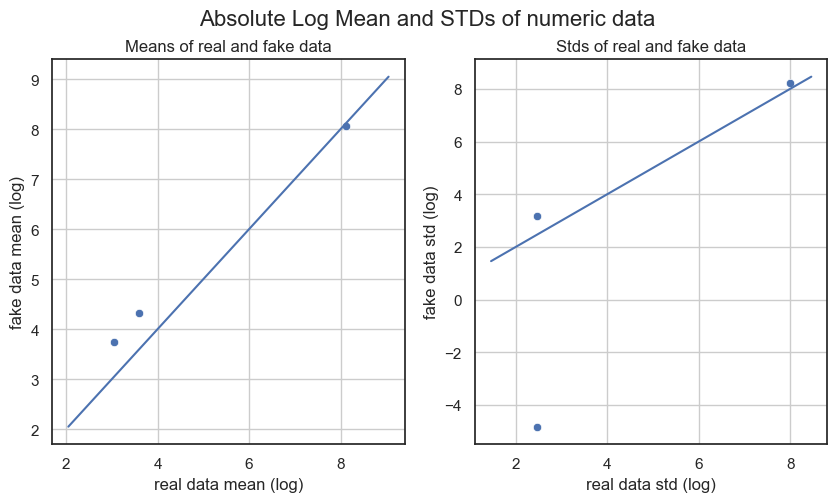

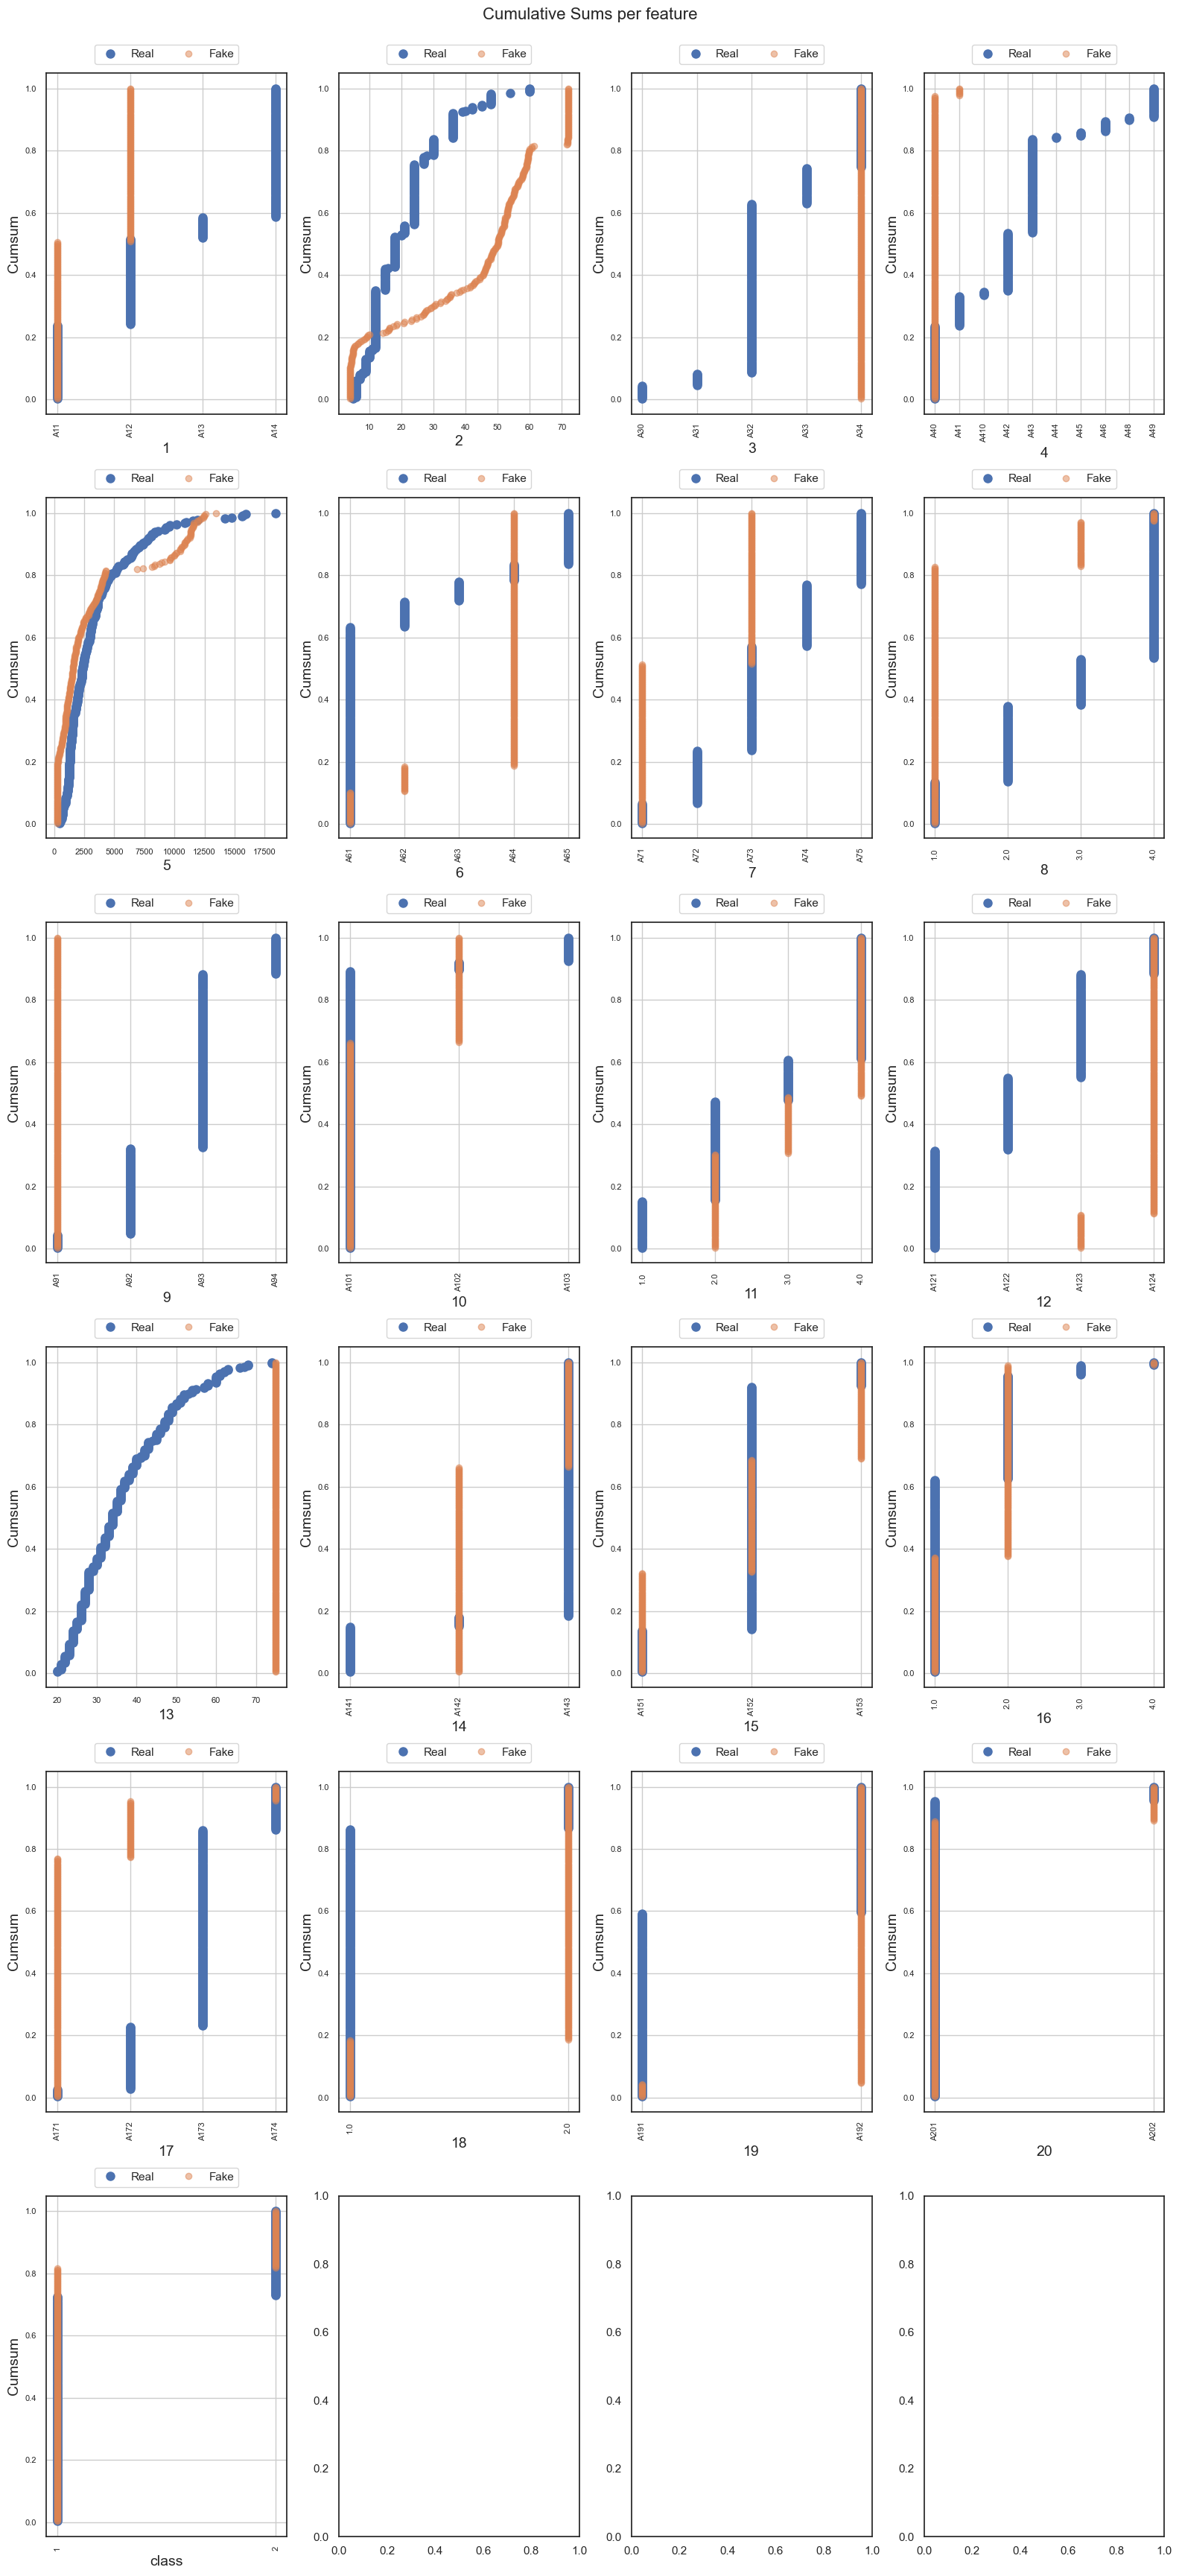

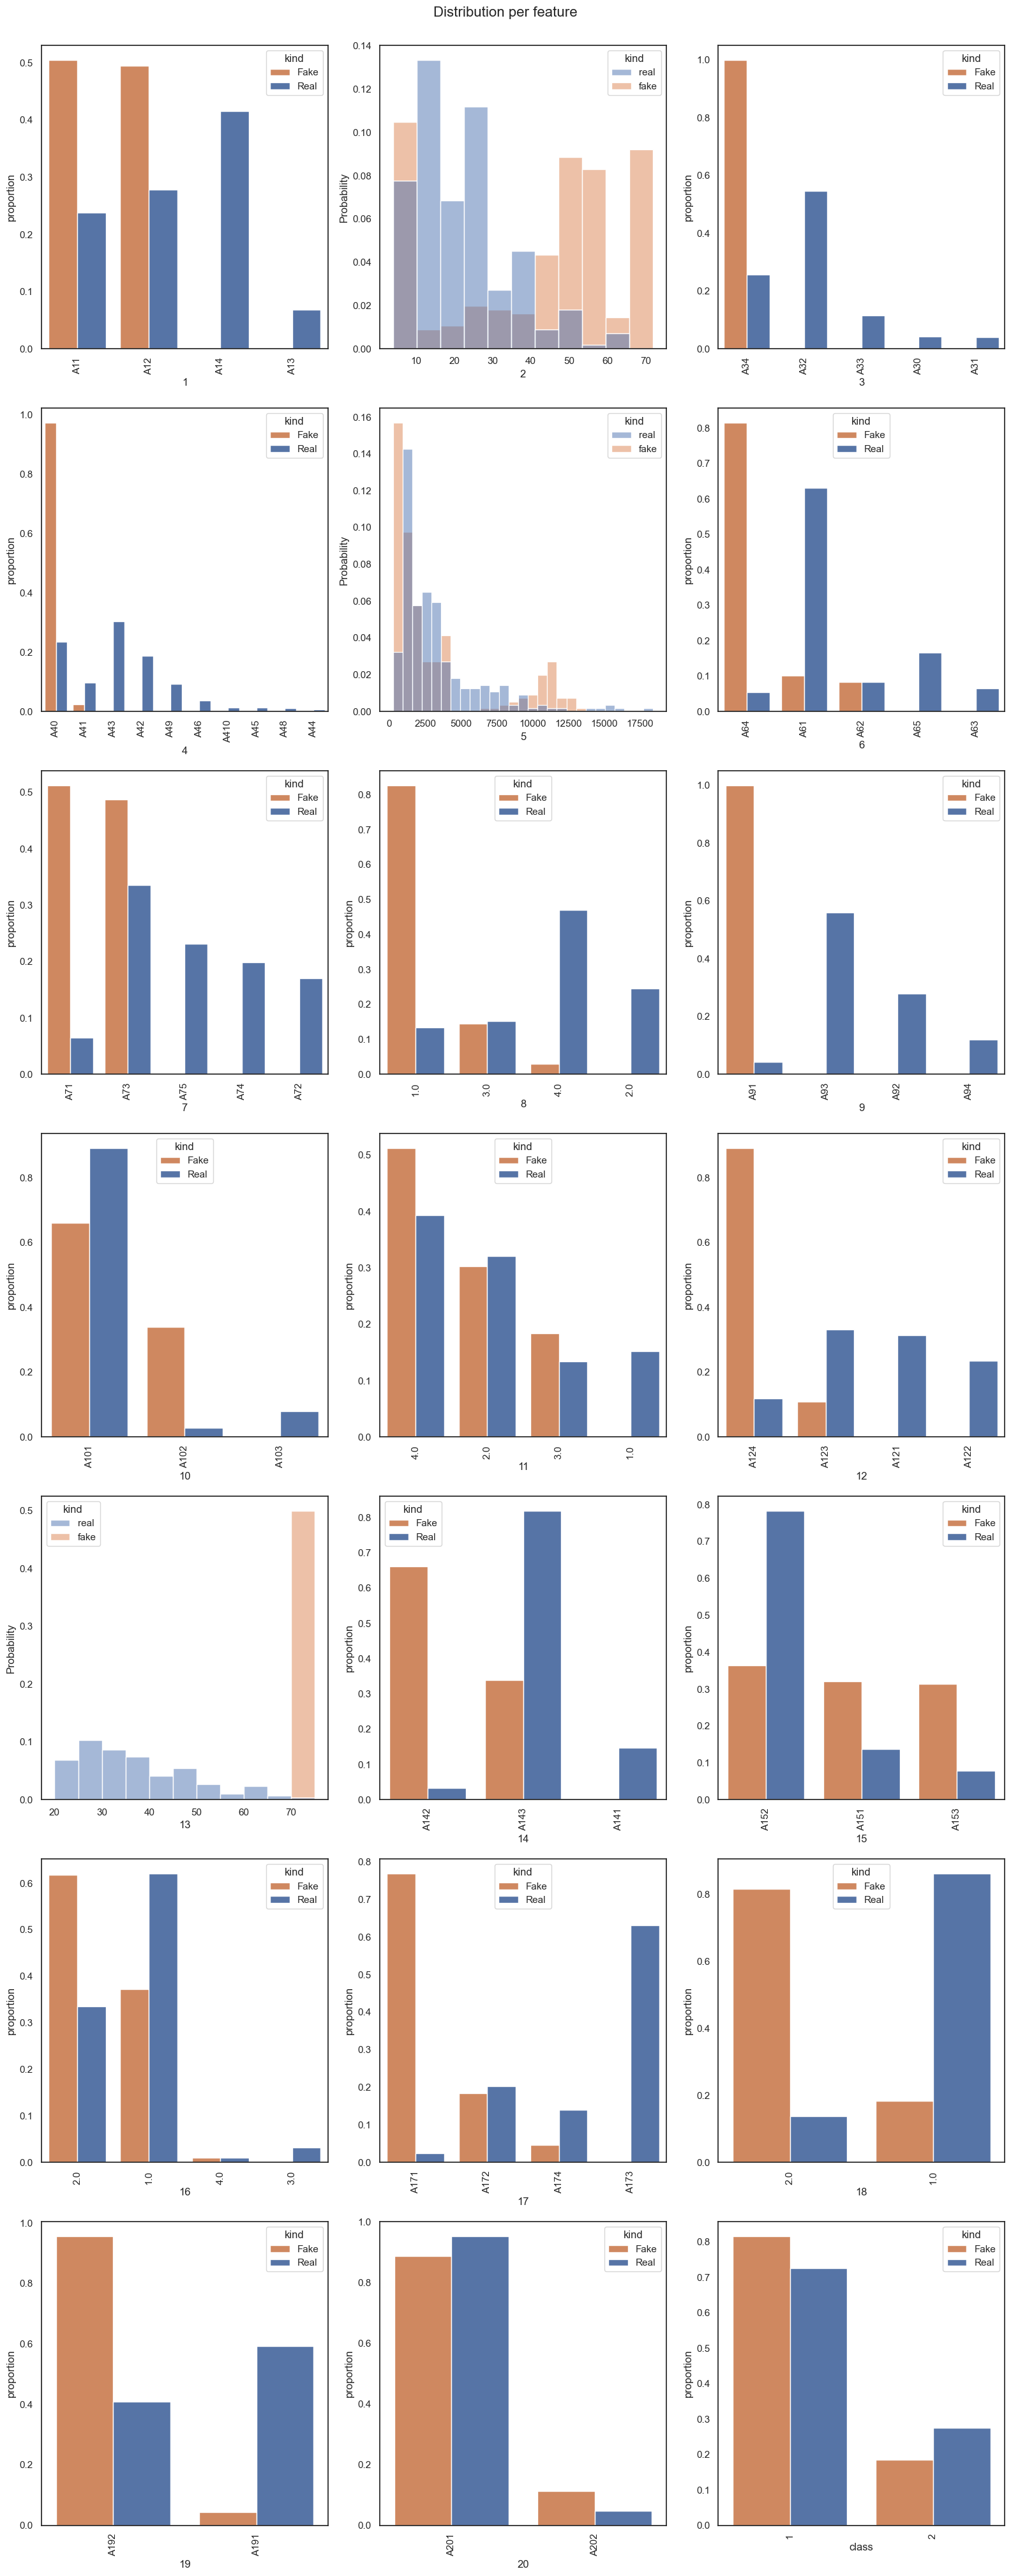

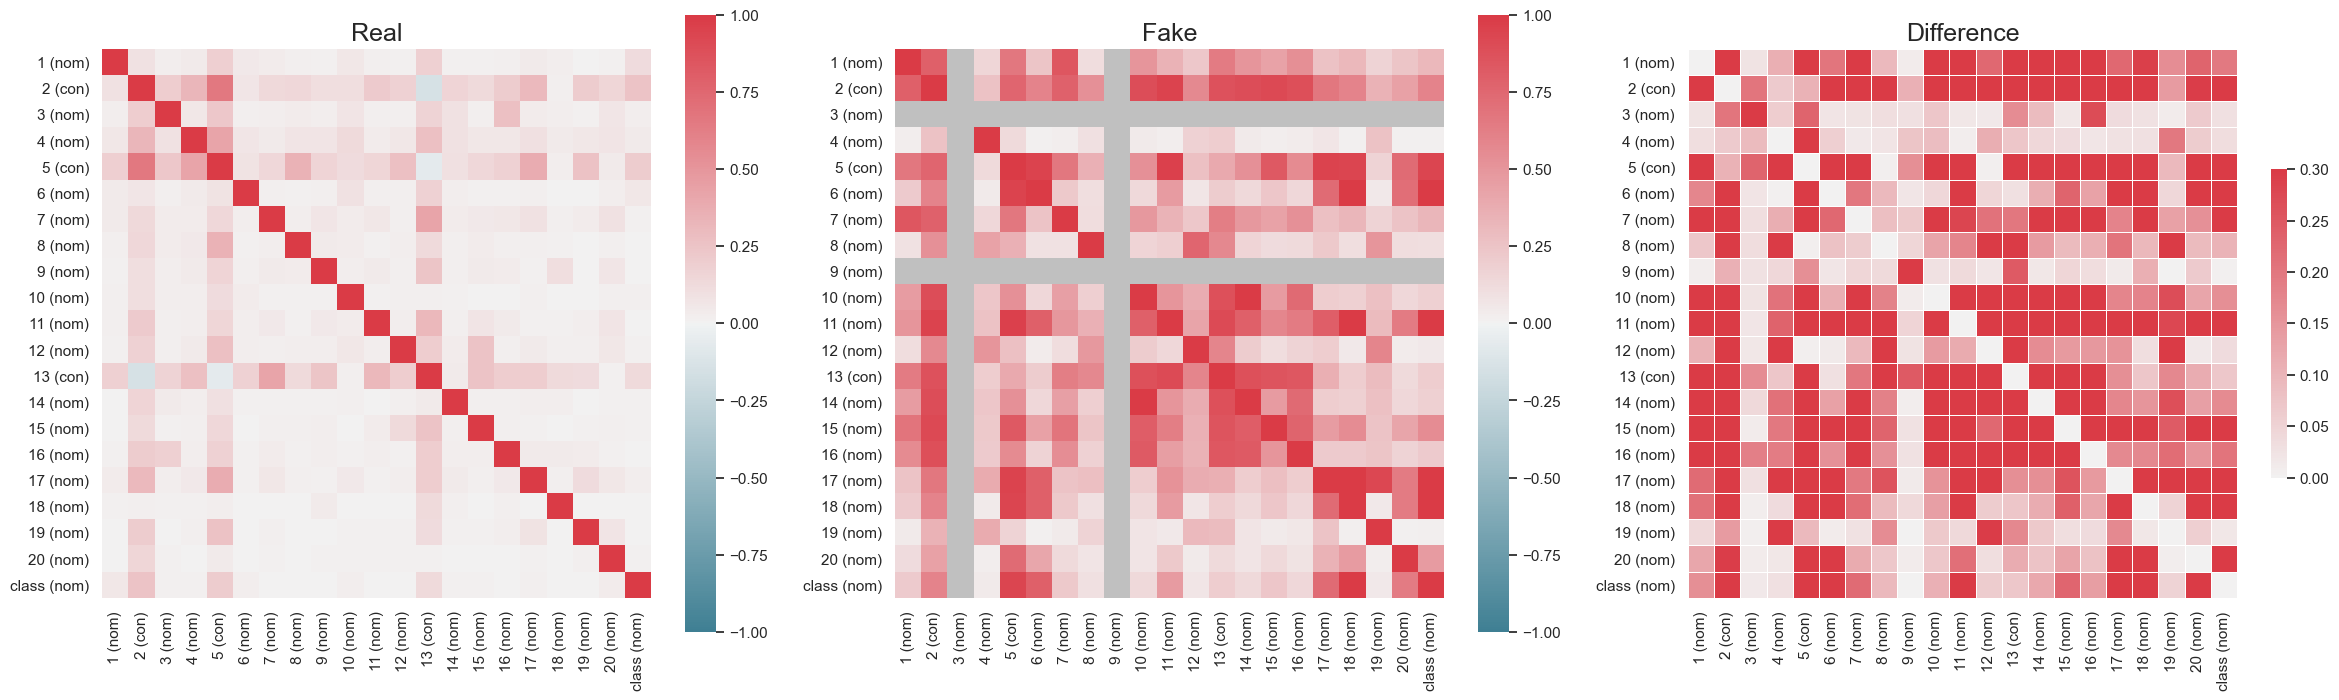

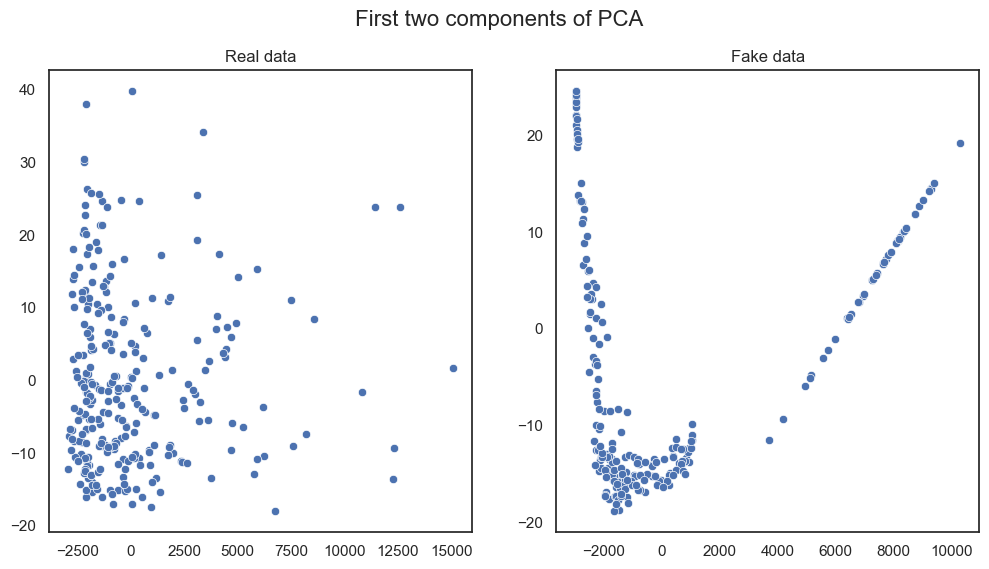

ValueError: Length of values (277) does not match length of index (466)

In [55]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df,
    fake_g_credit_df[d_c_predictions["discriminator_probability"] > 0.5],
    cat_cols=g_credit_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")